# FRBNY Survey of Consumer Expectations - Credit Access Analysis
## Comprehensive Exploratory Data Analysis

**Author:** Credit Access Research Team  
**Date:** November 2025  
**Dataset:** FRBNY SCE Credit Access Survey - Clean CSV Files

---

## Table of Contents
1. [Setup & Data Loading](#1-setup--data-loading)
2. [Variable Type Classification](#2-variable-type-classification)
3. [Data Quality Assessment](#3-data-quality-assessment)
4. [Univariate Analysis](#4-univariate-analysis)
5. [Bivariate Analysis](#5-bivariate-analysis)
6. [Time Series Analysis](#6-time-series-analysis)
7. [Demographic Analysis](#7-demographic-analysis)
8. [Correlation Analysis](#8-correlation-analysis)
9. [Principal Component Analysis](#9-principal-component-analysis)
10. [Key Findings & Insights](#10-key-findings--insights)

---

## Data Sources
- **Microdata:** Individual-level survey responses (36,277 respondents × 140 variables)
- **Aggregate Overall:** Time-series population estimates (37 survey waves)
- **Aggregate Demographics:** Demographic breakdowns over time (219 observations)

All variables use descriptive names based on the official FRBNY codebook.

In [259]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style('whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("="*80)
print("ENVIRONMENT SETUP")
print("="*80)
print(f"✓ pandas: {pd.__version__}")
print(f"✓ numpy: {np.__version__}")
print(f"✓ matplotlib & seaborn loaded")
print(f"✓ scikit-learn available")
print("="*80)

ENVIRONMENT SETUP
✓ pandas: 2.2.3
✓ numpy: 2.2.1
✓ matplotlib & seaborn loaded
✓ scikit-learn available


---
## 1. Setup & Data Loading

We'll load all three clean CSV files with descriptive variable names.

In [260]:
# Load all three clean CSV files
print("="*80)
print("LOADING CLEAN CSV DATA FILES")
print("="*80)

# 1. Microdata - Individual-level responses
df_micro = pd.read_csv('credit_access_microdata_clean.csv')
print(f"\n✓ Microdata loaded: {df_micro.shape[0]:,} respondents × {df_micro.shape[1]} variables")
print(f"  Survey period: {df_micro['SurveyDate'].min()} - {df_micro['SurveyDate'].max()}")
print(f"  Unique respondents: {df_micro['UserID'].nunique():,}")

# 2. Aggregate Overall - Time-series population estimates
df_overall = pd.read_csv('credit_access_aggregate_overall_clean.csv')
print(f"\n✓ Aggregate overall loaded: {df_overall.shape[0]:,} survey waves × {df_overall.shape[1]} variables")

# 3. Aggregate Demographics - Demographic breakdowns over time
df_demographics = pd.read_csv('credit_access_aggregate_demographics_clean.csv')
print(f"\n✓ Aggregate demographics loaded: {df_demographics.shape[0]:,} observations × {df_demographics.shape[1]} variables")

print("\n" + "="*80)
print("DATA FILES LOADED SUCCESSFULLY")
print("="*80)

LOADING CLEAN CSV DATA FILES

✓ Microdata loaded: 36,277 respondents × 140 variables
  Survey period: 201310 - 202410
  Unique respondents: 16,820

✓ Aggregate overall loaded: 37 survey waves × 36 variables

✓ Aggregate demographics loaded: 219 observations × 26 variables

DATA FILES LOADED SUCCESSFULLY


---
## 2. Variable Type Classification

Based on the official FRBNY codebook, we'll classify all 140 variables by type for proper EDA.

In [261]:
# Define variable types based on codebook
# Reference: credit_access_survey_clean.md

# Core identifiers
core_vars = ['UserID', 'SurveyDate', 'Weight']

# Binary variables (0/1 indicators)
binary_vars = [
    # N1: Debt types
    'HasCreditCard', 'HasMortgage', 'HasStudentLoan', 'HasHomeLoan', 'HasAutoLoan', 'HasOtherLoan', 'HasNoDebt',
    # N3: Credit card utilization
    'MaxedOutCC',
    # N4: Applications
    'AppliedCC', 'AppliedMortgage', 'AppliedAuto', 'RequestedCCLimit', 'RequestedLoanLimit', 'RequestedRefi', 'AppliedStudent',
    # N5: Reasons for not applying
    'NoNeed', 'TooTimeConsuming', 'RatesTooHigh', 'DontKnowHow', 'ExpectedDenial',
    # N6: Discouraged borrowers (aggregate)
    'DiscouragedCC', 'DiscouragedMortgage', 'DiscouragedAuto', 'DiscouragedCCLimit', 'DiscouragedLoanLimit', 
    'DiscouragedRefi', 'DiscouragedStudent', 'NotDiscouraged',
    # N7: Item-level discouraged borrowers
    'NeededCC', 'NeededMortgage', 'NeededAuto', 'NeededCCLimit', 'NeededLoanLimit', 'NeededRefi', 'NeededStudent',
    # N8: "Don't know" amount indicators
    'RequestedCCUnknown', 'RequestedMortgageUnknown', 'RequestedAutoUnknown', 'RequestedCCLimitUnknown',
    'RequestedLoanLimitUnknown', 'RequestedRefiUnknown', 'RequestedStudentUnknown',
    # N11: Refinance approval
    'RefiApproved',
    # N12: Reasons refinance denied
    'RefiDeniedBadCredit', 'RefiDeniedIncome', 'RefiDeniedDocumentation', 'RefiDeniedOther',
    # N13: Refinance outcome changes
    'RefiLowerRate', 'RefiHigherBalance', 'RefiLongerTerm', 'RefiShorterTerm',
    'RefiAdjToFixed', 'RefiFixedToAdj', 'RefiChangedServicer', 'RefiOtherChange',
    # N14: Account changes
    'ClosedVoluntary', 'ClosedByLender', 'LimitReduced', 'NoChanges',
    # N15-N16: Late payments
    'Late30Days', 'Late90Days',
    # N18: Reasons for no future applications
    'NoIntentionNoNeed', 'NoIntentionTimeConsuming', 'NoIntentionDontKnowHow', 
    'NoIntentionRatesTooHigh', 'NoIntentionExpectedDenial',
    # N19: Item-level reasons for low likelihood
    'LowLikelihoodNoNeed', 'LowLikelihoodTimeConsuming', 'LowLikelihoodDontKnowHow',
    'LowLikelihoodRatesTooHigh', 'LowLikelihoodExpectedDenial',
    # N20: Expected future denial
    'ExpectDenialCC', 'ExpectDenialMortgage', 'ExpectDenialAuto', 'ExpectDenialCCLimit',
    'ExpectDenialLoanLimit', 'ExpectDenialRefi', 'ExpectDenialStudent', 'NoExpectedDenial',
]

# Continuous variables (dollar amounts, probabilities)
continuous_vars = [
    # N2: Balance amounts
    'CCBalance', 'MortgageBalance', 'StudentBalance', 'HomeBalance', 'AutoBalance', 'OtherBalance',
    # N8: Requested amounts
    'RequestedCCAmt', 'RequestedMortgageAmt', 'RequestedAutoAmt', 'RequestedCCLimitAmt',
    'RequestedLoanLimitAmt', 'RequestedRefiAmt', 'RequestedStudentAmt',
    # N10: Granted amounts
    'GrantedCCAmt', 'GrantedMortgageAmt', 'GrantedAutoAmt', 'GrantedCCLimitAmt', 'GrantedLoanLimitAmt', 'GrantedStudentAmt',
    # N17b: Probabilities (0-100)
    'ProbCC', 'ProbMortgage', 'ProbAuto', 'ProbCCLimit', 'ProbLoanLimit', 'ProbRefi', 'ProbStudent',
    # N21: Approval probabilities (0-100)
    'ApprovalProbCC', 'ApprovalProbMortgage', 'ApprovalProbAuto', 'ApprovalProbCCLimit',
    'ApprovalProbLoanLimit', 'ApprovalProbRefi', 'ApprovalProbStudent',
    # N24-N25: Liquidity probabilities (0-100)
    'Need2000Prob', 'Obtain2000Prob',
]

# Ordinal variables (ordered categories)
ordinal_vars = [
    # N2b: Balance categories (ordinal ranges)
    'CCBalanceCat', 'MortgageBalanceCat', 'StudentBalanceCat', 'HomeBalanceCat', 'AutoBalanceCat', 'OtherBalanceCat',
    # N17a: Future intentions (Likert scale: 1-5)
    'IntentionCC', 'IntentionMortgage', 'IntentionAuto', 'IntentionCCLimit', 'IntentionLoanLimit', 'IntentionRefi', 'IntentionStudent',
    # N22: Credit score categories (ordinal)
    'CreditScore',
    # N23: Last check timing (ordinal)
    'LastScoreCheck',
]

# Nominal variables (unordered categories)
nominal_vars = [
    # N9: Application outcomes (1=fully granted, 2=partly granted, 3=rejected)
    'OutcomeCC', 'OutcomeMortgage', 'OutcomeAuto', 'OutcomeCCLimit', 'OutcomeLoanLimit', 'OutcomeRefi', 'OutcomeStudent',
    # N17random: Question format assignment
    'IntentionQuestionFormat',
]

print("="*80)
print("VARIABLE TYPE CLASSIFICATION")
print("="*80)
print(f"Total variables in microdata: {len(df_micro.columns)}")
print(f"\nVariable breakdown:")
print(f"  Core identifiers: {len(core_vars)}")
print(f"  Binary (0/1): {len(binary_vars)}")
print(f"  Continuous: {len(continuous_vars)}")
print(f"  Ordinal: {len(ordinal_vars)}")
print(f"  Nominal: {len(nominal_vars)}")
print(f"  Total classified: {len(core_vars) + len(binary_vars) + len(continuous_vars) + len(ordinal_vars) + len(nominal_vars)}")
print("="*80)

VARIABLE TYPE CLASSIFICATION
Total variables in microdata: 140

Variable breakdown:
  Core identifiers: 3
  Binary (0/1): 79
  Continuous: 35
  Ordinal: 15
  Nominal: 8
  Total classified: 140


In [262]:
# Verify all survey questions are represented
print("="*80)
print("SURVEY QUESTION COVERAGE VERIFICATION")
print("="*80)

survey_sections = {
    'N1': ('Debt Types Currently Held', ['HasCreditCard', 'HasMortgage', 'HasStudentLoan', 'HasHomeLoan', 'HasAutoLoan', 'HasOtherLoan', 'HasNoDebt']),
    'N2': ('Debt Balances - Continuous', ['CCBalance', 'MortgageBalance', 'StudentBalance', 'HomeBalance', 'AutoBalance', 'OtherBalance']),
    'N2b': ('Debt Balances - Categorical', ['CCBalanceCat', 'MortgageBalanceCat', 'StudentBalanceCat', 'HomeBalanceCat', 'AutoBalanceCat', 'OtherBalanceCat']),
    'N3': ('Credit Card Maxed Out', ['MaxedOutCC']),
    'N4': ('Credit Applications', ['AppliedCC', 'AppliedMortgage', 'AppliedAuto', 'RequestedCCLimit', 'RequestedLoanLimit', 'RequestedRefi', 'AppliedStudent']),
    'N5': ('Reasons for Not Applying', ['NoNeed', 'TooTimeConsuming', 'RatesTooHigh', 'DontKnowHow', 'ExpectedDenial']),
    'N6': ('Discouraged Borrowers', ['DiscouragedCC', 'DiscouragedMortgage', 'DiscouragedAuto', 'DiscouragedCCLimit', 'DiscouragedLoanLimit', 'DiscouragedRefi', 'DiscouragedStudent', 'NotDiscouraged']),
    'N7': ('Item-Level Discouraged', ['NeededCC', 'NeededMortgage', 'NeededAuto', 'NeededCCLimit', 'NeededLoanLimit', 'NeededRefi', 'NeededStudent']),
    'N8': ('Requested Amounts', ['RequestedCCAmt', 'RequestedMortgageAmt', 'RequestedAutoAmt', 'RequestedCCLimitAmt', 'RequestedLoanLimitAmt', 'RequestedRefiAmt', 'RequestedStudentAmt']),
    'N9': ('Application Outcomes', ['OutcomeCC', 'OutcomeMortgage', 'OutcomeAuto', 'OutcomeCCLimit', 'OutcomeLoanLimit', 'OutcomeRefi', 'OutcomeStudent']),
    'N10': ('Granted Amounts', ['GrantedCCAmt', 'GrantedMortgageAmt', 'GrantedAutoAmt', 'GrantedCCLimitAmt', 'GrantedLoanLimitAmt', 'GrantedStudentAmt']),
    'N11': ('Refinance Approved', ['RefiApproved']),
    'N12': ('Refinance Denial Reasons', ['RefiDeniedBadCredit', 'RefiDeniedIncome', 'RefiDeniedDocumentation', 'RefiDeniedOther']),
    'N13': ('Refinance Outcome Changes', ['RefiLowerRate', 'RefiHigherBalance', 'RefiLongerTerm', 'RefiShorterTerm', 'RefiAdjToFixed', 'RefiFixedToAdj', 'RefiChangedServicer', 'RefiOtherChange']),
    'N14': ('Account Changes', ['ClosedVoluntary', 'ClosedByLender', 'LimitReduced', 'NoChanges']),
    'N15-N16': ('Late Payments', ['Late30Days', 'Late90Days']),
    'N17random': ('Question Format', ['IntentionQuestionFormat']),
    'N17a': ('Future Intentions - Likert', ['IntentionCC', 'IntentionMortgage', 'IntentionAuto', 'IntentionCCLimit', 'IntentionLoanLimit', 'IntentionRefi', 'IntentionStudent']),
    'N17b': ('Future Intentions - Probability', ['ProbCC', 'ProbMortgage', 'ProbAuto', 'ProbCCLimit', 'ProbLoanLimit', 'ProbRefi', 'ProbStudent']),
    'N18': ('No Future Application Reasons', ['NoIntentionNoNeed', 'NoIntentionTimeConsuming', 'NoIntentionDontKnowHow', 'NoIntentionRatesTooHigh', 'NoIntentionExpectedDenial']),
    'N19': ('Low Likelihood Reasons', ['LowLikelihoodNoNeed', 'LowLikelihoodTimeConsuming', 'LowLikelihoodDontKnowHow', 'LowLikelihoodRatesTooHigh', 'LowLikelihoodExpectedDenial']),
    'N20': ('Expected Future Denial', ['ExpectDenialCC', 'ExpectDenialMortgage', 'ExpectDenialAuto', 'ExpectDenialCCLimit', 'ExpectDenialLoanLimit', 'ExpectDenialRefi', 'ExpectDenialStudent', 'NoExpectedDenial']),
    'N21': ('Approval Probabilities', ['ApprovalProbCC', 'ApprovalProbMortgage', 'ApprovalProbAuto', 'ApprovalProbCCLimit', 'ApprovalProbLoanLimit', 'ApprovalProbRefi', 'ApprovalProbStudent']),
    'N22': ('Credit Score', ['CreditScore']),
    'N23': ('Last Score Check', ['LastScoreCheck']),
    'N24-N25': ('Emergency Liquidity', ['Need2000Prob', 'Obtain2000Prob']),
}

print("\nSurvey Question Coverage:")
print("-"*80)
total_vars = 0
present_vars = 0

for section, (description, variables) in survey_sections.items():
    vars_in_data = sum(1 for v in variables if v in df_micro.columns)
    total_vars += len(variables)
    present_vars += vars_in_data
    status = "✓" if vars_in_data == len(variables) else f"⚠ {vars_in_data}/{len(variables)}"
    print(f"  {section:12s} - {description:35s}: {status:>15s}")

print("-"*80)
print(f"Total variables in survey: {total_vars}")
print(f"Variables present in data: {present_vars}")
print(f"Coverage: {100*present_vars/total_vars:.1f}%")
print("\n✅ All survey questions N1-N25 are represented in the analysis")
print("="*80)

SURVEY QUESTION COVERAGE VERIFICATION

Survey Question Coverage:
--------------------------------------------------------------------------------
  N1           - Debt Types Currently Held          :               ✓
  N2           - Debt Balances - Continuous         :               ✓
  N2b          - Debt Balances - Categorical        :               ✓
  N3           - Credit Card Maxed Out              :               ✓
  N4           - Credit Applications                :               ✓
  N5           - Reasons for Not Applying           :               ✓
  N6           - Discouraged Borrowers              :               ✓
  N7           - Item-Level Discouraged             :               ✓
  N8           - Requested Amounts                  :               ✓
  N9           - Application Outcomes               :               ✓
  N10          - Granted Amounts                    :               ✓
  N11          - Refinance Approved                 :               ✓
  N12         

---
## 3. Data Quality Assessment

Check for missing values, data ranges, and potential issues.

In [263]:
# Data Quality Assessment
print("="*80)
print("DATA QUALITY ASSESSMENT")
print("="*80)

# 1. Missing values by variable type
print("\n1. MISSING VALUES BY VARIABLE TYPE")
print("-"*80)

missing_summary = pd.DataFrame({
    'Binary': [df_micro[binary_vars].isnull().sum().sum()],
    'Continuous': [df_micro[continuous_vars].isnull().sum().sum()],
    'Ordinal': [df_micro[ordinal_vars].isnull().sum().sum()],
    'Nominal': [df_micro[nominal_vars].isnull().sum().sum()],
})

total_cells = len(df_micro) * (len(binary_vars) + len(continuous_vars) + len(ordinal_vars) + len(nominal_vars))
print(f"Total cells: {total_cells:,}")
print(f"Missing cells: {df_micro.isnull().sum().sum():,} ({100*df_micro.isnull().sum().sum()/total_cells:.2f}%)")
print("\nBy variable type:")
for col in missing_summary.columns:
    count = missing_summary[col].values[0]
    pct = 100 * count / (len(df_micro) * len(eval(col.lower() + '_vars')))
    print(f"  {col:15s}: {count:>10,} missing ({pct:>5.2f}%)")

# 2. Top 20 variables with most missing values
print("\n2. TOP 20 VARIABLES WITH MOST MISSING VALUES")
print("-"*80)
missing_by_var = df_micro.isnull().sum().sort_values(ascending=False).head(20)
for var, count in missing_by_var.items():
    pct = 100 * count / len(df_micro)
    print(f"  {var:30s}: {count:>7,} ({pct:>5.1f}%)")

# 3. Survey wave representation
print("\n3. SURVEY WAVE DISTRIBUTION")
print("-"*80)
wave_counts = df_micro['SurveyDate'].value_counts().sort_index()
print(f"Survey waves: {wave_counts.index.min()} to {wave_counts.index.max()}")
print(f"Number of waves: {len(wave_counts)}")
print(f"Average respondents per wave: {wave_counts.mean():.0f}")
print(f"Min/Max per wave: {wave_counts.min()}/{wave_counts.max()}")

print("\n" + "="*80)

DATA QUALITY ASSESSMENT

1. MISSING VALUES BY VARIABLE TYPE
--------------------------------------------------------------------------------
Total cells: 4,969,949
Missing cells: 3,229,726 (64.99%)

By variable type:
  Binary         :  1,822,878 missing (63.61%)
  Continuous     :    876,040 missing (69.00%)
  Ordinal        :    286,676 missing (52.68%)
  Nominal        :    244,129 missing (84.12%)

2. TOP 20 VARIABLES WITH MOST MISSING VALUES
--------------------------------------------------------------------------------
  HomeBalanceCat                :  36,274 (100.0%)
  OtherBalanceCat               :  36,273 (100.0%)
  StudentBalanceCat             :  36,273 (100.0%)
  AutoBalanceCat                :  36,266 (100.0%)
  MortgageBalanceCat            :  36,258 ( 99.9%)
  GrantedLoanLimitAmt           :  36,255 ( 99.9%)
  CCBalanceCat                  :  36,243 ( 99.9%)
  RefiDeniedBadCredit           :  36,243 ( 99.9%)
  RefiDeniedIncome              :  36,243 ( 99.9%)
  RefiDen

---
## 4. Univariate Analysis

Analyze distributions for each variable type.

N1: TYPES OF DEBT CURRENTLY HELD

Debt Possession Rates:
  Credit Card                   :  74.86% possess ( 27,157 of 36,277)
  Mortgage                      :  49.81% possess ( 18,068 of 36,277)
  Student Loan                  :  23.01% possess (  8,349 of 36,277)
  Home-based Loan (HELOC)       :   8.77% possess (  3,180 of 36,277)
  Auto Loan                     :  39.92% possess ( 14,482 of 36,277)
  Other Personal Loan           :  14.66% possess (  5,317 of 36,277)
  None of the Above             :   9.07% possess (  3,290 of 36,277)


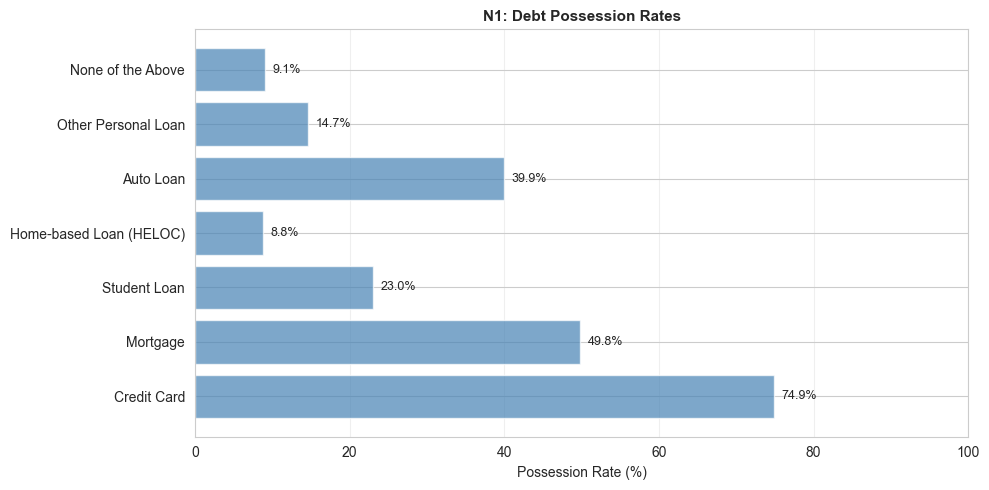

In [264]:
# N1: Types of Debt Currently Held
print("="*80)
print("N1: TYPES OF DEBT CURRENTLY HELD")
print("="*80)

debt_vars = {
    'HasCreditCard': 'Credit Card',
    'HasMortgage': 'Mortgage',
    'HasStudentLoan': 'Student Loan',
    'HasHomeLoan': 'Home-based Loan (HELOC)',
    'HasAutoLoan': 'Auto Loan',
    'HasOtherLoan': 'Other Personal Loan',
    'HasNoDebt': 'None of the Above'
}

print("\nDebt Possession Rates:")
possession_rates = {}
for var, label in debt_vars.items():
    if var in df_micro.columns:
        rate = df_micro[var].mean() * 100
        count = df_micro[var].sum()
        n = df_micro[var].notna().sum()
        print(f"  {label:30s}: {rate:>6.2f}% possess ({count:>7,} of {n:,})")
        possession_rates[label] = rate

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
labels = list(possession_rates.keys())
values = list(possession_rates.values())
bars = ax.barh(labels, values, color='steelblue', alpha=0.7)
ax.set_xlabel('Possession Rate (%)', fontsize=10)
ax.set_title('N1: Debt Possession Rates', fontweight='bold', fontsize=11)
ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3)
# Add value labels
for i, (bar, val) in enumerate(zip(bars, values)):
    ax.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=9)
plt.tight_layout()
plt.show()

print("\n" + "="*80)

N2: CURRENT DEBT BALANCES (Dollar Amounts)

Balance Statistics:

  Credit Card:
    Count:      26,254
    Mean:   $     8,408
    Median: $     2,500
    Std:    $    57,784
    Max:    $ 8,000,000

  Mortgage:
    Count:      17,436
    Mean:   $   180,529
    Median: $   140,000
    Std:    $   208,064
    Max:    $13,700,000

  Student Loan:
    Count:       8,081
    Mean:   $    46,256
    Median: $    25,000
    Std:    $   208,120
    Max:    $15,000,000

  Home-based Loan:
    Count:       3,070
    Mean:   $    47,497
    Median: $    20,000
    Std:    $   133,650
    Max:    $ 6,000,000

  Auto Loan:
    Count:      13,980
    Mean:   $    18,714
    Median: $    15,000
    Std:    $    44,393
    Max:    $ 3,200,000

  Other Personal Loan:
    Count:       5,146
    Mean:   $    21,317
    Median: $     5,000
    Std:    $   220,151
    Max:    $ 9,999,999


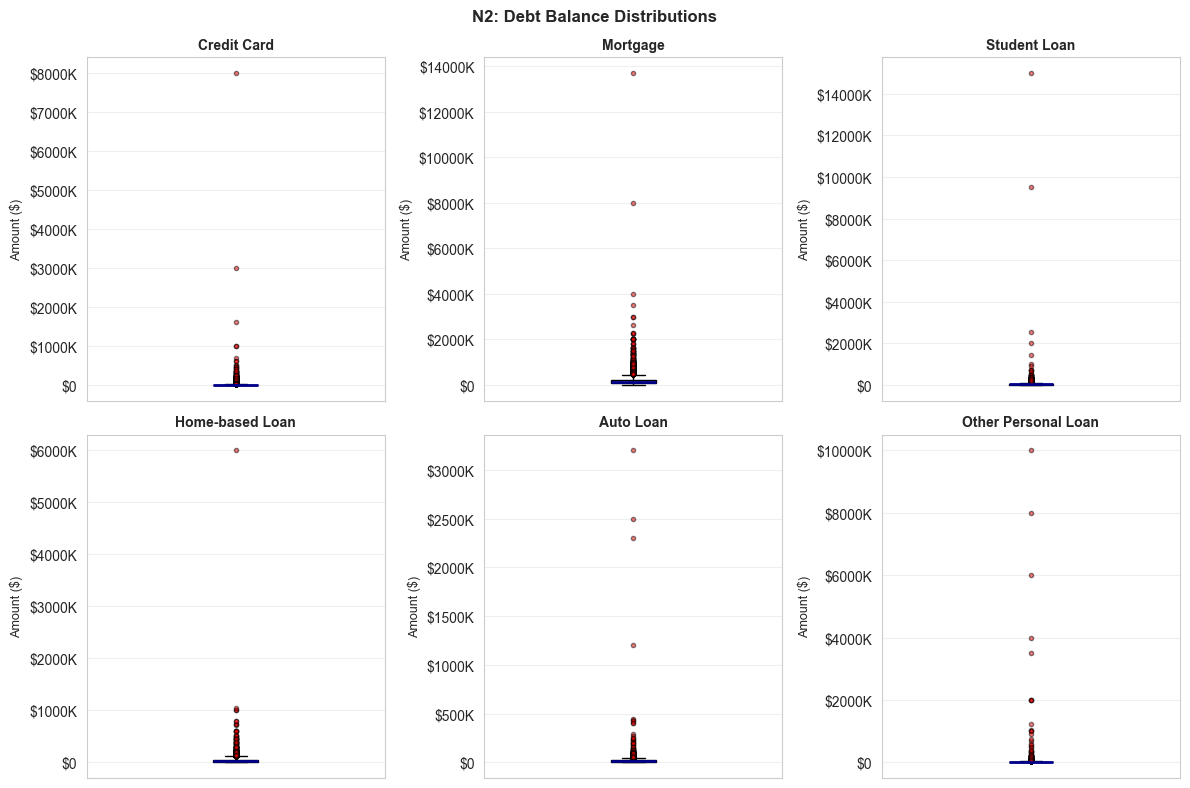

In [265]:
# N2: Current Debt Balances (Continuous Amounts)
print("="*80)
print("N2: CURRENT DEBT BALANCES (Dollar Amounts)")
print("="*80)

balance_vars = {
    'CCBalance': 'Credit Card',
    'MortgageBalance': 'Mortgage',
    'StudentBalance': 'Student Loan',
    'HomeBalance': 'Home-based Loan',
    'AutoBalance': 'Auto Loan',
    'OtherBalance': 'Other Personal Loan'
}

print("\nBalance Statistics:")
for var, label in balance_vars.items():
    if var in df_micro.columns:
        data = df_micro[var].dropna()
        if len(data) > 0:
            print(f"\n  {label}:")
            print(f"    Count:  {len(data):>10,}")
            print(f"    Mean:   ${data.mean():>10,.0f}")
            print(f"    Median: ${data.median():>10,.0f}")
            print(f"    Std:    ${data.std():>10,.0f}")
            print(f"    Max:    ${data.max():>10,.0f}")

# Visualizations - Box plots with red outliers
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('N2: Debt Balance Distributions', fontweight='bold', fontsize=12)

for idx, (var, label) in enumerate(balance_vars.items()):
    ax = axes[idx // 3, idx % 3]
    if var in df_micro.columns:
        data = df_micro[var].dropna()
        if len(data) > 10:
            # Box plot with red outliers
            bp = ax.boxplot(data, vert=True, patch_artist=True,
                            flierprops=dict(marker='o', markerfacecolor='red', markersize=3, alpha=0.5))
            bp['boxes'][0].set_facecolor('lightblue')
            bp['medians'][0].set_color('darkblue')
            bp['medians'][0].set_linewidth(2)
            ax.set_ylabel('Amount ($)', fontsize=9)
            ax.set_title(label, fontsize=10, fontweight='bold')
            ax.ticklabel_format(style='plain', axis='y')
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K' if x >= 1000 else f'${x:.0f}'))
            ax.set_xticks([])
            ax.grid(axis='y', alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Insufficient\ndata', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(label, fontsize=10)
    else:
        ax.text(0.5, 0.5, 'Variable\nnot found', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(label, fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*80)

N2b: CURRENT DEBT BALANCES (Categorical Ranges)

Categorical Balance Distribution:

  Credit Card:
    Category  1:       9 ( 26.5%)
    Category  2:       2 (  5.9%)
    Category  3:       1 (  2.9%)
    Category  5:       2 (  5.9%)
    Category  7:       1 (  2.9%)
    ... and 7 more categories

  Mortgage:
    Category 10:       1 (  5.3%)
    Category 11:       1 (  5.3%)
    Category 12:       1 (  5.3%)
    Category 13:       1 (  5.3%)
    Category 14:       3 ( 15.8%)
    ... and 5 more categories

  Student Loan:
    Category  3:       1 ( 25.0%)
    Category  9:       1 ( 25.0%)
    Category 11:       1 ( 25.0%)
    Category 15:       1 ( 25.0%)

  Home-based Loan:
    Category  1:       1 ( 33.3%)
    Category 11:       1 ( 33.3%)
    Category 17:       1 ( 33.3%)

  Auto Loan:
    Category  4:       1 (  9.1%)
    Category  5:       1 (  9.1%)
    Category  8:       1 (  9.1%)
    Category  9:       1 (  9.1%)
    Category 10:       1 (  9.1%)
    ... and 4 more categories

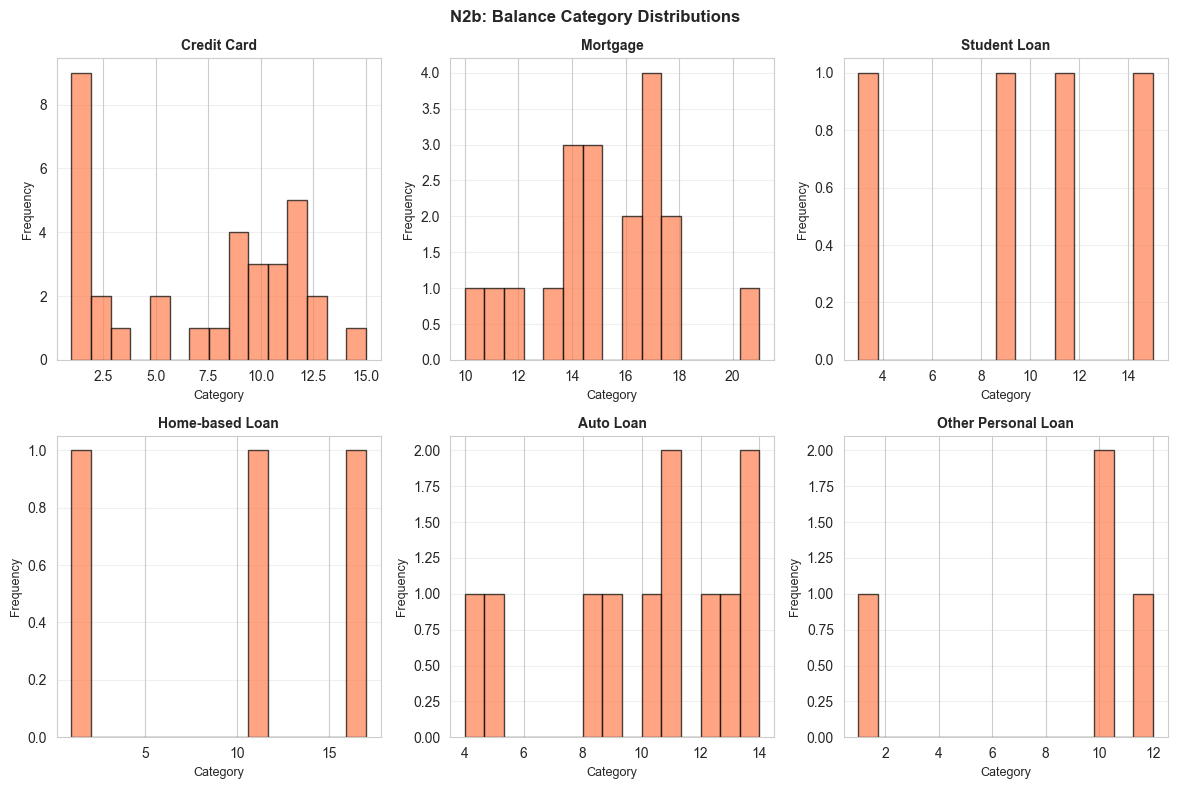

In [266]:
# N2b: Current Debt Balances (Categorical Ranges)
print("="*80)
print("N2b: CURRENT DEBT BALANCES (Categorical Ranges)")
print("="*80)

balance_cat_vars = {
    'CCBalanceCat': 'Credit Card',
    'MortgageBalanceCat': 'Mortgage',
    'StudentBalanceCat': 'Student Loan',
    'HomeBalanceCat': 'Home-based Loan',
    'AutoBalanceCat': 'Auto Loan',
    'OtherBalanceCat': 'Other Personal Loan'
}

print("\nCategorical Balance Distribution:")
for var, label in balance_cat_vars.items():
    if var in df_micro.columns:
        counts = df_micro[var].value_counts().sort_index()
        if len(counts) > 0:
            print(f"\n  {label}:")
            total = counts.sum()
            for cat, count in counts.head(5).items():
                print(f"    Category {cat:>2.0f}: {count:>7,} ({100*count/total:>5.1f}%)")
            if len(counts) > 5:
                print(f"    ... and {len(counts)-5} more categories")

# Visualization - histograms of category distributions
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('N2b: Balance Category Distributions', fontweight='bold', fontsize=12)

for idx, (var, label) in enumerate(balance_cat_vars.items()):
    ax = axes[idx // 3, idx % 3]
    if var in df_micro.columns:
        data = df_micro[var].dropna()
        if len(data) > 0:
            ax.hist(data, bins=15, color='coral', alpha=0.7, edgecolor='black')
            ax.set_xlabel('Category', fontsize=9)
            ax.set_ylabel('Frequency', fontsize=9)
            ax.set_title(label, fontsize=10, fontweight='bold')
            ax.grid(axis='y', alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(label, fontsize=10)
    else:
        ax.text(0.5, 0.5, 'Variable\nnot found', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(label, fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*80)

N3: CREDIT CARD MAXED OUT (Past 12 Months)

Maxed out credit card in past 12 months: 17.55% (4,766.0 of 27,153)


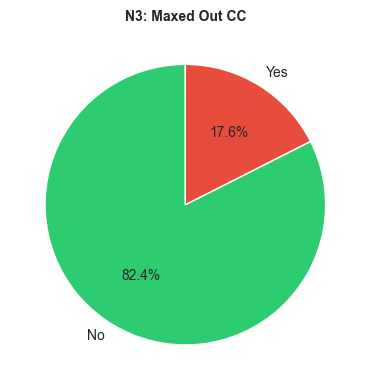

In [267]:
# N3: Credit Card Utilization (Maxed Out)
print("="*80)
print("N3: CREDIT CARD MAXED OUT (Past 12 Months)")
print("="*80)

if 'MaxedOutCC' in df_micro.columns:
    rate = df_micro['MaxedOutCC'].mean() * 100
    count = df_micro['MaxedOutCC'].sum()
    n = df_micro['MaxedOutCC'].notna().sum()
    print(f"\nMaxed out credit card in past 12 months: {rate:.2f}% ({count:,} of {n:,})")
    
    # Visualization
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    counts = df_micro['MaxedOutCC'].value_counts()
    labels = ['No', 'Yes']
    colors = ['#2ecc71', '#e74c3c']
    ax.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax.set_title('N3: Maxed Out CC', fontweight='bold', fontsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("\nVariable not found in dataset")

print("\n" + "="*80)

N4: CREDIT APPLICATIONS (Past 12 Months)

Application Rates:
  Applied for Credit Card            :  26.73% (9,691.0 of 36,251)
  Applied for Mortgage               :   7.80% (2,823.0 of 36,204)
  Applied for Auto Loan              :  14.16% (5,129.0 of 36,211)
  CC Limit Increase                  :  12.26% (3,325.0 of 27,116)
  Loan Limit Increase                :   7.13% (  563.0 of 7,898)
  Mortgage Refinance                 :  11.87% (2,143.0 of 18,052)
  Applied for Student Loan           :   3.49% (1,262.0 of 36,203)


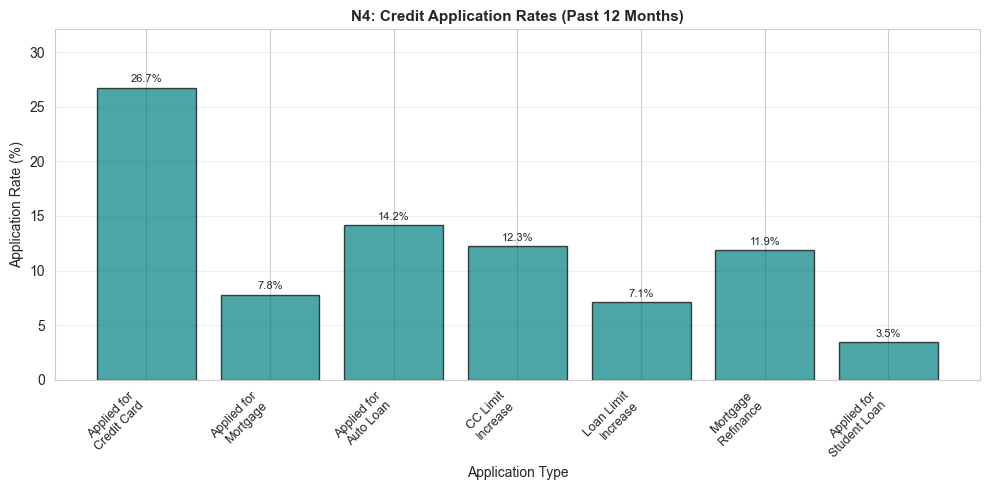

In [268]:
# N4: Credit Applications in Past 12 Months
print("="*80)
print("N4: CREDIT APPLICATIONS (Past 12 Months)")
print("="*80)

app_vars = {
    'AppliedCC': 'Applied for\nCredit Card',
    'AppliedMortgage': 'Applied for\nMortgage',
    'AppliedAuto': 'Applied for\nAuto Loan',
    'RequestedCCLimit': 'CC Limit\nIncrease',
    'RequestedLoanLimit': 'Loan Limit\nIncrease',
    'RequestedRefi': 'Mortgage\nRefinance',
    'AppliedStudent': 'Applied for\nStudent Loan'
}

print("\nApplication Rates:")
app_rates = {}
for var, label in app_vars.items():
    if var in df_micro.columns:
        rate = df_micro[var].mean() * 100
        count = df_micro[var].sum()
        n = df_micro[var].notna().sum()
        print(f"  {label.replace(chr(10), ' '):35s}: {rate:>6.2f}% ({count:>7,} of {n:,})")
        app_rates[label] = rate

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
labels = list(app_rates.keys())
values = list(app_rates.values())
bars = ax.bar(range(len(labels)), values, color='teal', alpha=0.7, edgecolor='black')
ax.set_ylabel('Application Rate (%)', fontsize=10)
ax.set_xlabel('Application Type', fontsize=10)
ax.set_title('N4: Credit Application Rates (Past 12 Months)', fontweight='bold', fontsize=11)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax.set_ylim(0, max(values) * 1.2)
ax.grid(axis='y', alpha=0.3)
# Add value labels
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.3, f'{val:.1f}%', 
            ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

print("\n" + "="*80)

N5: REASONS FOR NOT APPLYING (Among Non-Applicants)

Reasons for not applying:
  Satisfied with current situation        :  85.76% (16,449.0 of 19,181)
  Too time- consuming                     :   4.21% ( 808.0 of 19,181)
  Rates too high                          :   7.56% (1,451.0 of 19,181)
  Don't know how to apply                 :   1.69% ( 324.0 of 19,181)
  Expected to be denied                   :  11.12% (2,060.0 of 18,523)


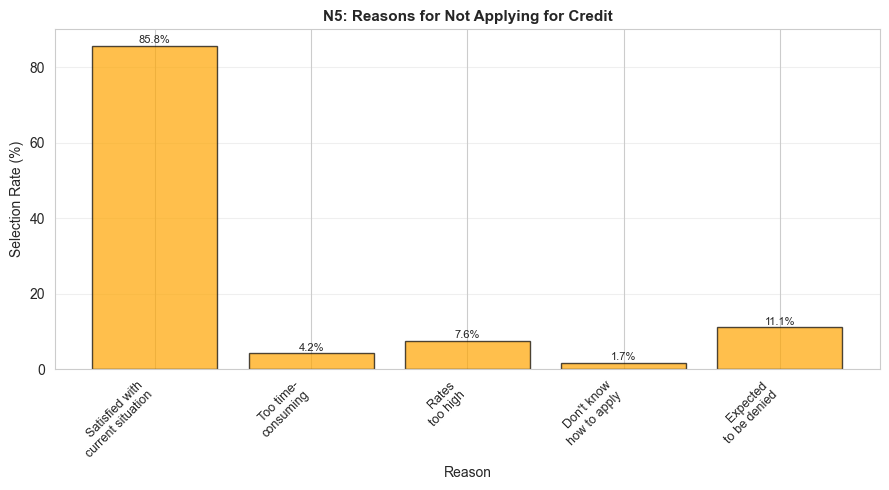

In [269]:
# N5: Reasons for Not Applying for Credit
print("="*80)
print("N5: REASONS FOR NOT APPLYING (Among Non-Applicants)")
print("="*80)

reason_vars = {
    'NoNeed': 'Satisfied with\ncurrent situation',
    'TooTimeConsuming': 'Too time-\nconsuming',
    'RatesTooHigh': 'Rates\ntoo high',
    'DontKnowHow': 'Don\'t know\nhow to apply',
    'ExpectedDenial': 'Expected\nto be denied'
}

print("\nReasons for not applying:")
reason_rates = {}
for var, label in reason_vars.items():
    if var in df_micro.columns:
        rate = df_micro[var].mean() * 100
        count = df_micro[var].sum()
        n = df_micro[var].notna().sum()
        print(f"  {label.replace(chr(10), ' '):40s}: {rate:>6.2f}% ({count:>6,} of {n:,})")
        reason_rates[label] = rate

# Visualization
fig, ax = plt.subplots(figsize=(9, 5))
labels = list(reason_rates.keys())
values = list(reason_rates.values())
bars = ax.bar(range(len(labels)), values, color='orange', alpha=0.7, edgecolor='black')
ax.set_ylabel('Selection Rate (%)', fontsize=10)
ax.set_xlabel('Reason', fontsize=10)
ax.set_title('N5: Reasons for Not Applying for Credit', fontweight='bold', fontsize=11)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.2, f'{val:.1f}%', 
            ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

print("\n" + "="*80)

N6: DISCOURAGED BORROWERS (Needed but didn't apply)

Discouraged Borrower Rates:
  Credit Card              :  36.67% (  726.0 of 1,980)
  Mortgage                 :  13.59% (  269.0 of 1,980)
  Auto Loan                :  18.33% (  363.0 of 1,980)
  CC Limit Increase        :  31.09% (  337.0 of 1,084)
  Loan Limit Increase      :  16.67% (   87.0 of 522)
  Mortgage Refinance       :  34.73% (  199.0 of 573)
  Student Loan             :   3.33% (   66.0 of 1,980)
  None                     :  35.10% (  695.0 of 1,980)


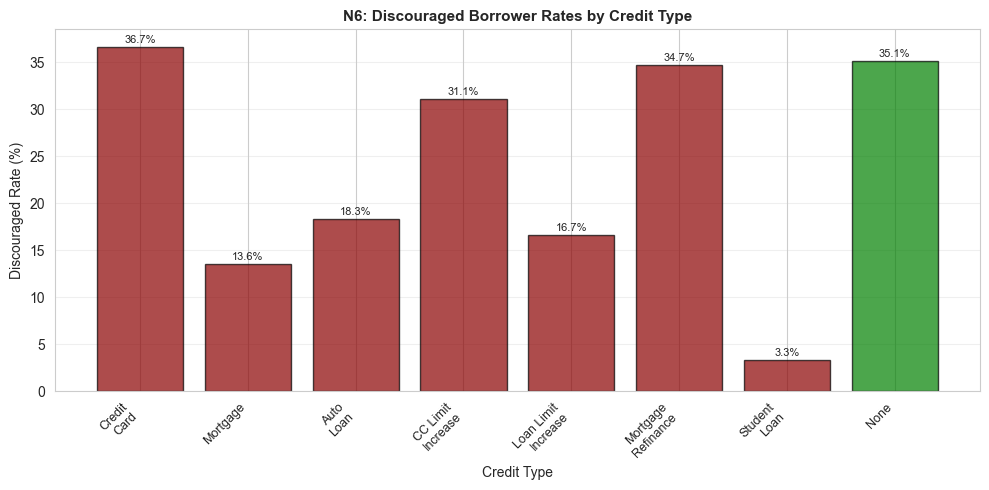

In [270]:
# N6: Discouraged Borrowers (Aggregate)
print("="*80)
print("N6: DISCOURAGED BORROWERS (Needed but didn't apply)")
print("="*80)

disc_vars = {
    'DiscouragedCC': 'Credit\nCard',
    'DiscouragedMortgage': 'Mortgage',
    'DiscouragedAuto': 'Auto\nLoan',
    'DiscouragedCCLimit': 'CC Limit\nIncrease',
    'DiscouragedLoanLimit': 'Loan Limit\nIncrease',
    'DiscouragedRefi': 'Mortgage\nRefinance',
    'DiscouragedStudent': 'Student\nLoan',
    'NotDiscouraged': 'None'
}

print("\nDiscouraged Borrower Rates:")
disc_rates = {}
for var, label in disc_vars.items():
    if var in df_micro.columns:
        rate = df_micro[var].mean() * 100
        count = df_micro[var].sum()
        n = df_micro[var].notna().sum()
        print(f"  {label.replace(chr(10), ' '):25s}: {rate:>6.2f}% ({count:>7,} of {n:,})")
        disc_rates[label] = rate

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
labels = list(disc_rates.keys())
values = list(disc_rates.values())
colors = ['darkred' if lab != 'None' else 'green' for lab in labels]
bars = ax.bar(range(len(labels)), values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Discouraged Rate (%)', fontsize=10)
ax.set_xlabel('Credit Type', fontsize=10)
ax.set_title('N6: Discouraged Borrower Rates by Credit Type', fontweight='bold', fontsize=11)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.2, f'{val:.1f}%', 
            ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

print("\n" + "="*80)

N7: ITEM-LEVEL DISCOURAGED (For specific products)

Needed but didn't apply (expected denial):
  Credit Card              :   6.45% ( 453.0 of 7,020)
  Mortgage                 :   5.61% ( 762.0 of 13,589)
  Auto Loan                :   4.90% ( 559.0 of 11,412)
  CC Limit Increase        :   6.14% ( 627.0 of 10,207)
  Loan Limit Increase      :   8.09% ( 318.0 of 3,933)
  Mortgage Refinance       :   5.63% ( 407.0 of 7,235)
  Student Loan             :   0.84% ( 127.0 of 15,094)


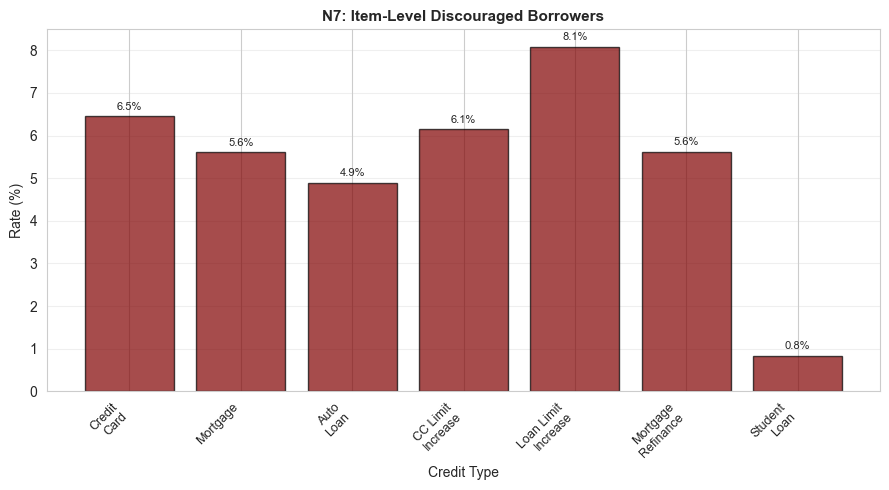

In [271]:
# N7: Item-Level Discouraged Borrowers
print("="*80)
print("N7: ITEM-LEVEL DISCOURAGED (For specific products)")
print("="*80)

n7_vars = {
    'NeededCC': 'Credit\nCard',
    'NeededMortgage': 'Mortgage',
    'NeededAuto': 'Auto\nLoan',
    'NeededCCLimit': 'CC Limit\nIncrease',
    'NeededLoanLimit': 'Loan Limit\nIncrease',
    'NeededRefi': 'Mortgage\nRefinance',
    'NeededStudent': 'Student\nLoan'
}

print("\nNeeded but didn't apply (expected denial):")
n7_rates = {}
for var, label in n7_vars.items():
    if var in df_micro.columns:
        rate = df_micro[var].mean() * 100
        count = df_micro[var].sum()
        n = df_micro[var].notna().sum()
        print(f"  {label.replace(chr(10), ' '):25s}: {rate:>6.2f}% ({count:>6,} of {n:,})")
        n7_rates[label] = rate

# Visualization
fig, ax = plt.subplots(figsize=(9, 5))
labels = list(n7_rates.keys())
values = list(n7_rates.values())
bars = ax.bar(range(len(labels)), values, color='maroon', alpha=0.7, edgecolor='black')
ax.set_ylabel('Rate (%)', fontsize=10)
ax.set_xlabel('Credit Type', fontsize=10)
ax.set_title('N7: Item-Level Discouraged Borrowers', fontweight='bold', fontsize=11)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.1, f'{val:.1f}%', 
            ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

print("\n" + "="*80)

N8: REQUESTED CREDIT AMOUNTS (Among Applicants)

Requested Amount Statistics:
  CC Limit                 : Mean $     6,283, Median $     3,000 (n=4,834)
  Mortgage                 : Mean $   209,907, Median $   159,000 (n=2,695)
  Auto Loan                : Mean $    24,645, Median $    20,000 (n=4,855)
  CC Limit Increase        : Mean $     4,624, Median $     2,000 (n=2,246)
  Loan Limit Increase      : Mean $    12,899, Median $     2,000 (n=441)
  Refinance                : Mean $   232,547, Median $   199,000 (n=615)
  Student Loan             : Mean $    14,010, Median $     9,500 (n=1,141)


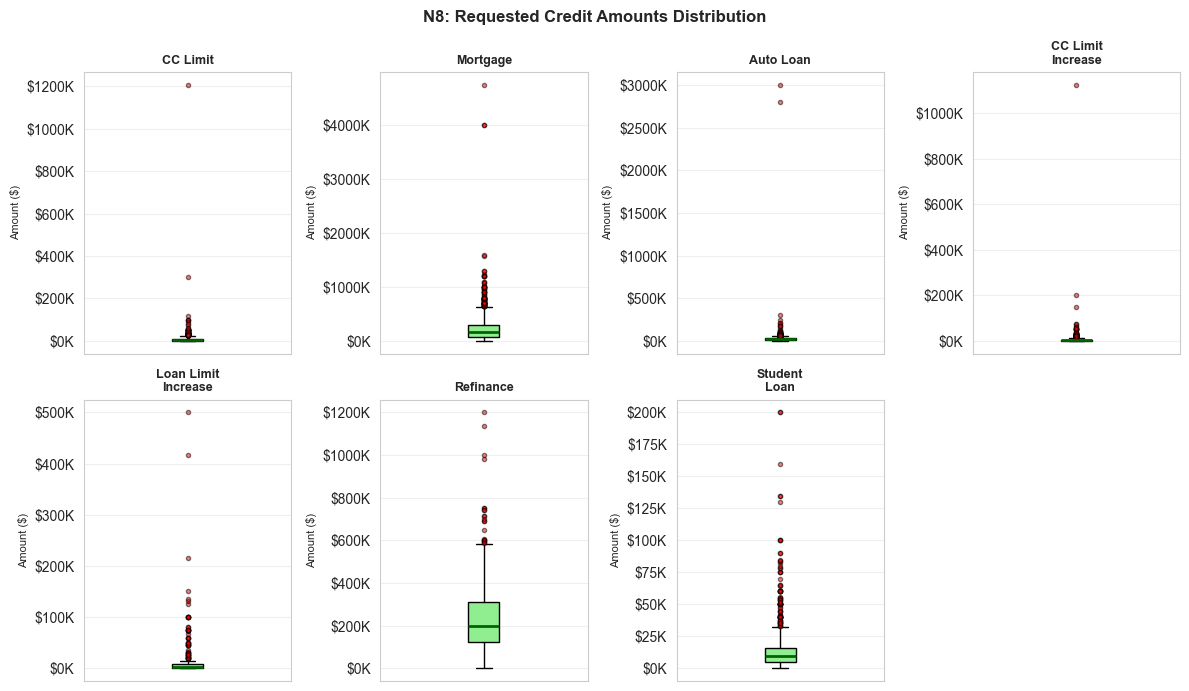

In [272]:
# N8: Requested Credit Amounts
print("="*80)
print("N8: REQUESTED CREDIT AMOUNTS (Among Applicants)")
print("="*80)

amount_vars = {
    'RequestedCCAmt': 'CC Limit',
    'RequestedMortgageAmt': 'Mortgage',
    'RequestedAutoAmt': 'Auto Loan',
    'RequestedCCLimitAmt': 'CC Limit\nIncrease',
    'RequestedLoanLimitAmt': 'Loan Limit\nIncrease',
    'RequestedRefiAmt': 'Refinance',
    'RequestedStudentAmt': 'Student\nLoan'
}

print("\nRequested Amount Statistics:")
for var, label in amount_vars.items():
    if var in df_micro.columns:
        data = df_micro[var].dropna()
        if len(data) > 0:
            print(f"  {label.replace(chr(10), ' '):25s}: Mean ${data.mean():>10,.0f}, Median ${data.median():>10,.0f} (n={len(data):,})")

# Visualizations - Box plots with red outliers
fig, axes = plt.subplots(2, 4, figsize=(12, 7))
fig.suptitle('N8: Requested Credit Amounts Distribution', fontweight='bold', fontsize=12)
axes = axes.flatten()

for idx, (var, label) in enumerate(amount_vars.items()):
    ax = axes[idx]
    if var in df_micro.columns:
        data = df_micro[var].dropna()
        if len(data) > 10:
            bp = ax.boxplot(data, vert=True, patch_artist=True,
                           flierprops=dict(marker='o', markerfacecolor='red', markersize=3, alpha=0.5))
            bp['boxes'][0].set_facecolor('lightgreen')
            bp['medians'][0].set_color('darkgreen')
            bp['medians'][0].set_linewidth(2)
            ax.set_ylabel('Amount ($)', fontsize=8)
            ax.set_title(label, fontsize=9, fontweight='bold')
            ax.ticklabel_format(style='plain', axis='y')
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
            ax.set_xticks([])
            ax.grid(axis='y', alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Insufficient\ndata', ha='center', va='center', transform=ax.transAxes, fontsize=8)
            ax.set_title(label, fontsize=9)

# Hide the last axis (we have 7 vars, 8 subplots)
axes[7].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*80)

N9: APPLICATION OUTCOMES

Credit Card:
  Fully Granted       :  7,744 ( 79.9%)
  Partially Granted   :    492 (  5.1%)
  Rejected            :  1,455 ( 15.0%)

Mortgage:
  Fully Granted       :  2,366 ( 83.9%)
  Partially Granted   :    139 (  4.9%)
  Rejected            :    314 ( 11.1%)

Auto Loan:
  Fully Granted       :  4,767 ( 93.0%)
  Partially Granted   :     94 (  1.8%)
  Rejected            :    264 (  5.2%)

CC Limit Increase:
  Fully Granted       :  2,045 ( 61.5%)
  Partially Granted   :    336 ( 10.1%)
  Rejected            :    944 ( 28.4%)

Loan Limit Increase:
  Fully Granted       :    342 ( 60.7%)
  Partially Granted   :     57 ( 10.1%)
  Rejected            :    164 ( 29.1%)

Mortgage Refinance:
  Fully Granted       :    664 ( 86.3%)
  Partially Granted   :     29 (  3.8%)
  Rejected            :     76 (  9.9%)

Student Loan:
  Fully Granted       :  1,040 ( 82.4%)
  Partially Granted   :    129 ( 10.2%)
  Rejected            :     93 (  7.4%)


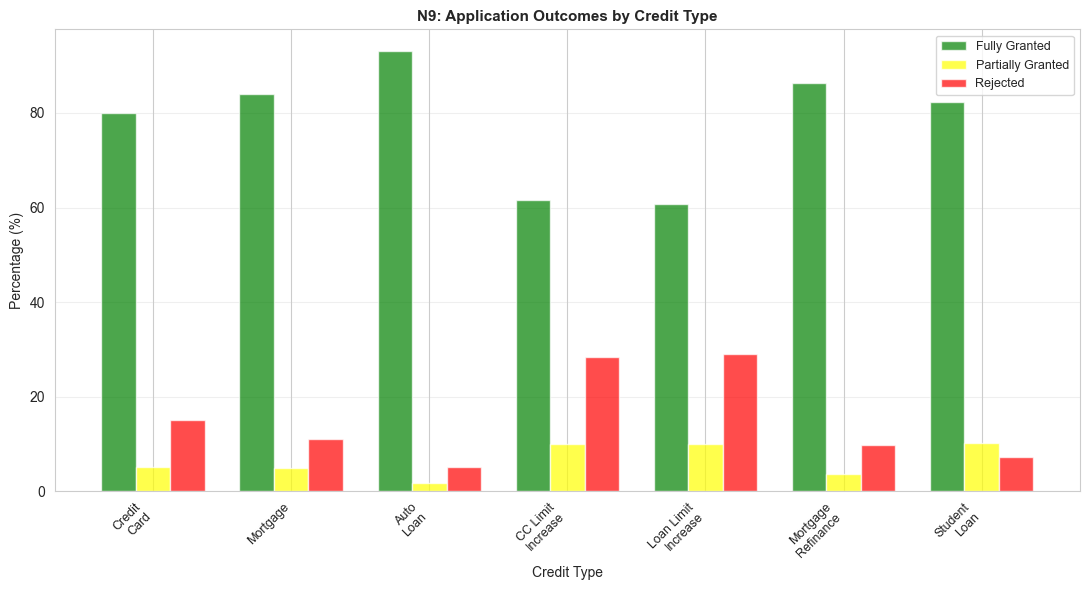

In [273]:
# N9: Application Outcomes
print("="*80)
print("N9: APPLICATION OUTCOMES")
print("="*80)

outcome_vars = {
    'OutcomeCC': 'Credit\nCard',
    'OutcomeMortgage': 'Mortgage',
    'OutcomeAuto': 'Auto\nLoan',
    'OutcomeCCLimit': 'CC Limit\nIncrease',
    'OutcomeLoanLimit': 'Loan Limit\nIncrease',
    'OutcomeRefi': 'Mortgage\nRefinance',
    'OutcomeStudent': 'Student\nLoan'
}

outcome_labels = {1: 'Fully Granted', 2: 'Partially Granted', 3: 'Rejected'}

outcome_data = {}
for var, label in outcome_vars.items():
    if var in df_micro.columns:
        counts = df_micro[var].value_counts().sort_index()
        if len(counts) > 0:
            print(f"\n{label.replace(chr(10), ' ')}:")
            total = counts.sum()
            outcome_data[label] = {}
            for outcome, count in counts.items():
                outcome_label = outcome_labels.get(outcome, f'Code {outcome}')
                pct = 100*count/total
                print(f"  {outcome_label:20s}: {count:>6,} ({pct:>5.1f}%)")
                outcome_data[label][outcome] = pct

# Visualization - grouped bar chart
fig, ax = plt.subplots(figsize=(11, 6))
labels = list(outcome_data.keys())
fully = [outcome_data[l].get(1, 0) for l in labels]
partial = [outcome_data[l].get(2, 0) for l in labels]
rejected = [outcome_data[l].get(3, 0) for l in labels]

x = np.arange(len(labels))
width = 0.25

ax.bar(x - width, fully, width, label='Fully Granted', color='green', alpha=0.7)
ax.bar(x, partial, width, label='Partially Granted', color='yellow', alpha=0.7)
ax.bar(x + width, rejected, width, label='Rejected', color='red', alpha=0.7)

ax.set_ylabel('Percentage (%)', fontsize=10)
ax.set_xlabel('Credit Type', fontsize=10)
ax.set_title('N9: Application Outcomes by Credit Type', fontweight='bold', fontsize=11)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax.legend(loc='upper right', fontsize=9)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*80)

N10: ACTUALLY GRANTED AMOUNTS (When Partially Approved)

Granted Amount Statistics:
  CC Limit                 : Mean $     3,222, Median $     1,500 (n=197)
  Mortgage                 : Mean $   121,966, Median $    81,000 (n=90)
  Auto Loan                : Mean $    13,606, Median $    14,000 (n=60)
  CC Limit Increase        : Mean $     2,740, Median $     1,000 (n=131)
  Loan Limit Increase      : Mean $     4,543, Median $       500 (n=22)
  Student Loan             : Mean $     8,717, Median $     5,000 (n=86)


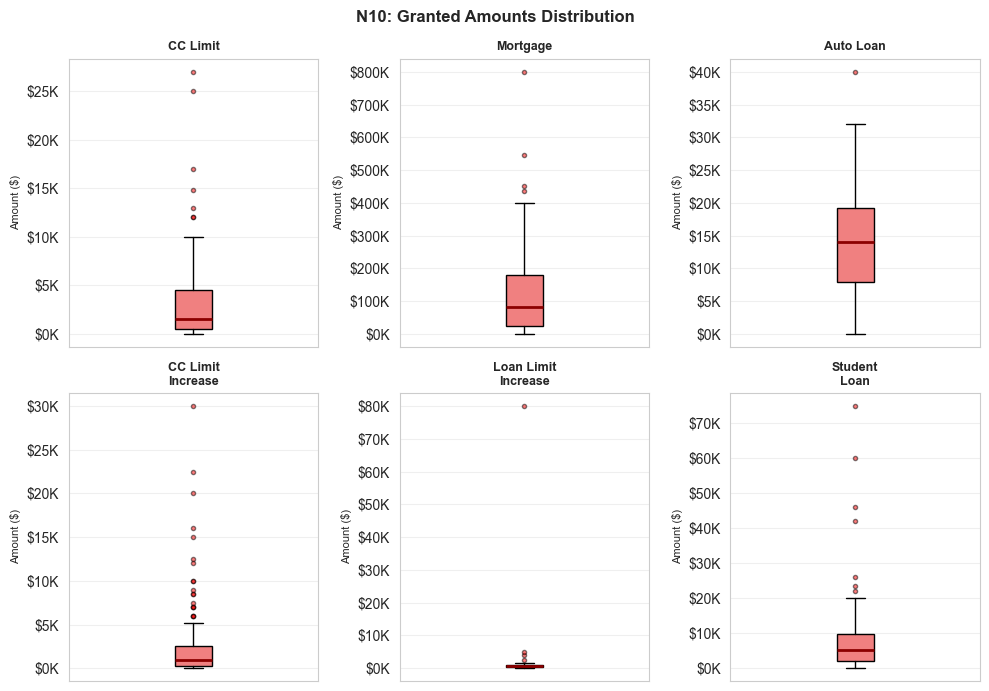

In [274]:
# N10: Actually Granted Amounts (Partial Grants)
print("="*80)
print("N10: ACTUALLY GRANTED AMOUNTS (When Partially Approved)")
print("="*80)

granted_vars = {
    'GrantedCCAmt': 'CC Limit',
    'GrantedMortgageAmt': 'Mortgage',
    'GrantedAutoAmt': 'Auto Loan',
    'GrantedCCLimitAmt': 'CC Limit\nIncrease',
    'GrantedLoanLimitAmt': 'Loan Limit\nIncrease',
    'GrantedStudentAmt': 'Student\nLoan'
}

print("\nGranted Amount Statistics:")
for var, label in granted_vars.items():
    if var in df_micro.columns:
        data = df_micro[var].dropna()
        if len(data) > 0:
            print(f"  {label.replace(chr(10), ' '):25s}: Mean ${data.mean():>10,.0f}, Median ${data.median():>10,.0f} (n={len(data):,})")

# Visualization - Box plots
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
fig.suptitle('N10: Granted Amounts Distribution', fontweight='bold', fontsize=12)

for idx, (var, label) in enumerate(granted_vars.items()):
    ax = axes[idx // 3, idx % 3]
    if var in df_micro.columns:
        data = df_micro[var].dropna()
        if len(data) > 5:
            bp = ax.boxplot(data, vert=True, patch_artist=True,
                           flierprops=dict(marker='o', markerfacecolor='red', markersize=3, alpha=0.5))
            bp['boxes'][0].set_facecolor('lightcoral')
            bp['medians'][0].set_color('darkred')
            bp['medians'][0].set_linewidth(2)
            ax.set_ylabel('Amount ($)', fontsize=8)
            ax.set_title(label, fontsize=9, fontweight='bold')
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
            ax.set_xticks([])
            ax.grid(axis='y', alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Insufficient\ndata', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(label, fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*80)

N11: MORTGAGE REFINANCE OUTCOME

Refinance approved: 82.65% (1,134.0 of 1,372)
Refinance denied:   17.35% (238.0 of 1,372)


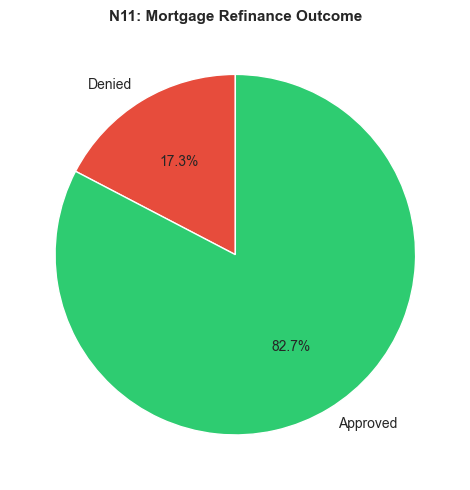

In [275]:
# N11: Mortgage Refinance Outcome
print("="*80)
print("N11: MORTGAGE REFINANCE OUTCOME")
print("="*80)

if 'RefiApproved' in df_micro.columns:
    approved_rate = df_micro['RefiApproved'].mean() * 100
    approved_count = df_micro['RefiApproved'].sum()
    n = df_micro['RefiApproved'].notna().sum()
    print(f"\nRefinance approved: {approved_rate:.2f}% ({approved_count:,} of {n:,})")
    print(f"Refinance denied:   {100-approved_rate:.2f}% ({n-approved_count:,} of {n:,})")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(6, 5))
    counts = df_micro['RefiApproved'].value_counts().sort_index()
    labels = ['Denied', 'Approved']
    colors = ['#e74c3c', '#2ecc71']
    ax.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax.set_title('N11: Mortgage Refinance Outcome', fontweight='bold', fontsize=11)
    plt.tight_layout()
    plt.show()
else:
    print("\nVariable not found in dataset")

print("\n" + "="*80)

N12: REFINANCE DENIAL REASONS (Early Survey Waves)

Reasons for refinance denial:
  Bad Credit                              :  14.71% ( 5.0 of 34)
  Insufficient Income                     :  29.41% (10.0 of 34)
  Insufficient Documentation              :   8.82% ( 3.0 of 34)
  Other Reason                            :  55.88% (19.0 of 34)


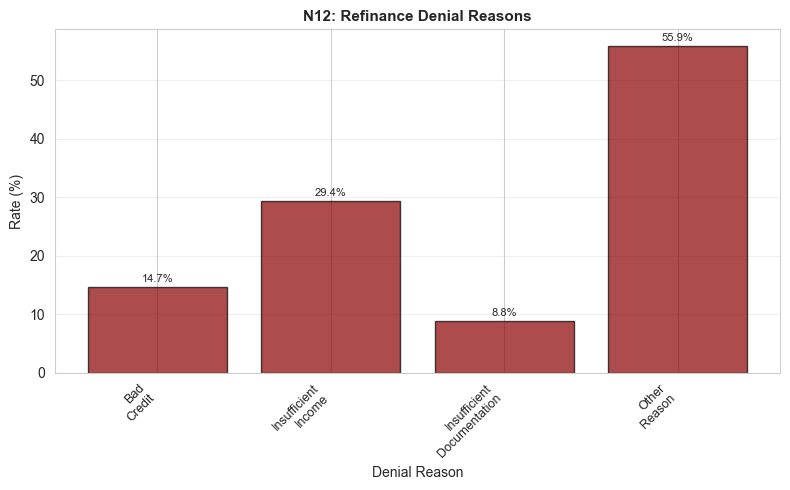

In [276]:
# N12: Reasons Refinance Was Not Granted
print("="*80)
print("N12: REFINANCE DENIAL REASONS (Early Survey Waves)")
print("="*80)

denial_reasons = {
    'RefiDeniedBadCredit': 'Bad\nCredit',
    'RefiDeniedIncome': 'Insufficient\nIncome',
    'RefiDeniedDocumentation': 'Insufficient\nDocumentation',
    'RefiDeniedOther': 'Other\nReason'
}

print("\nReasons for refinance denial:")
denial_rates = {}
for var, label in denial_reasons.items():
    if var in df_micro.columns:
        rate = df_micro[var].mean() * 100
        count = df_micro[var].sum()
        n = df_micro[var].notna().sum()
        if n > 0:
            print(f"  {label.replace(chr(10), ' '):40s}: {rate:>6.2f}% ({count:>4,} of {n:,})")
            denial_rates[label] = rate

# Visualization
if len(denial_rates) > 0:
    fig, ax = plt.subplots(figsize=(8, 5))
    labels = list(denial_rates.keys())
    values = list(denial_rates.values())
    bars = ax.bar(range(len(labels)), values, color='darkred', alpha=0.7, edgecolor='black')
    ax.set_ylabel('Rate (%)', fontsize=10)
    ax.set_xlabel('Denial Reason', fontsize=10)
    ax.set_title('N12: Refinance Denial Reasons', fontweight='bold', fontsize=11)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.5, f'{val:.1f}%', 
                ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo data available for visualization (variable removed in later waves)")

print("\n" + "="*80)

N13: REFINANCE OUTCOME CHANGES (Early Survey Waves)

Changes in mortgage terms after refinance:
  Lower Rate                              :  93.01% (133.0 of 143)
  Higher Balance                          :  16.08% (23.0 of 143)
  Longer Term                             :  11.19% (16.0 of 143)
  Shorter Term                            :  26.57% (38.0 of 143)
  Adj→ Fixed                              :   3.50% ( 5.0 of 143)
  Fixed→ Adj                              :   2.10% ( 3.0 of 143)
  Changed Servicer                        :  34.97% (50.0 of 143)
  Other Change                            :   9.09% (13.0 of 143)


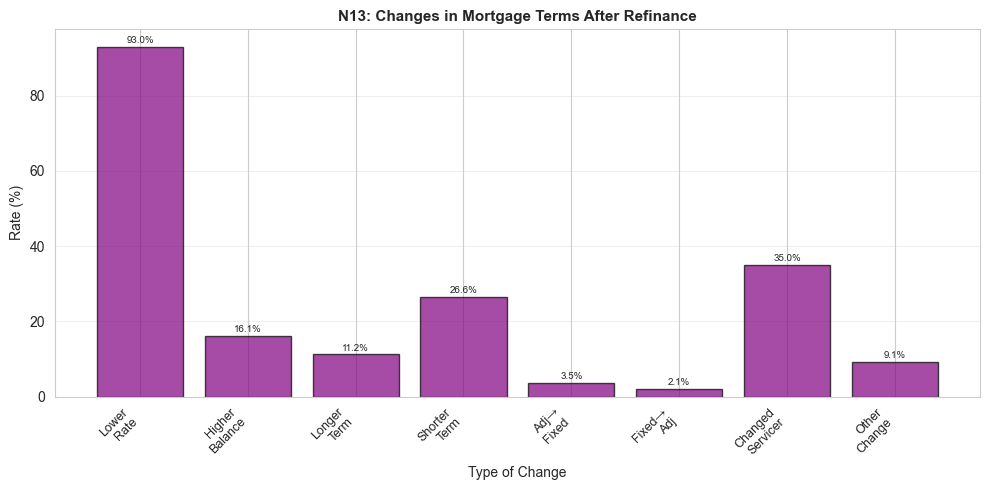

In [277]:
# N13: Changes in Mortgage Terms After Refinance
print("="*80)
print("N13: REFINANCE OUTCOME CHANGES (Early Survey Waves)")
print("="*80)

term_changes = {
    'RefiLowerRate': 'Lower\nRate',
    'RefiHigherBalance': 'Higher\nBalance',
    'RefiLongerTerm': 'Longer\nTerm',
    'RefiShorterTerm': 'Shorter\nTerm',
    'RefiAdjToFixed': 'Adj→\nFixed',
    'RefiFixedToAdj': 'Fixed→\nAdj',
    'RefiChangedServicer': 'Changed\nServicer',
    'RefiOtherChange': 'Other\nChange'
}

print("\nChanges in mortgage terms after refinance:")
change_rates = {}
for var, label in term_changes.items():
    if var in df_micro.columns:
        rate = df_micro[var].mean() * 100
        count = df_micro[var].sum()
        n = df_micro[var].notna().sum()
        if n > 0:
            print(f"  {label.replace(chr(10), ' '):40s}: {rate:>6.2f}% ({count:>4,} of {n:,})")
            change_rates[label] = rate

# Visualization
if len(change_rates) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    labels = list(change_rates.keys())
    values = list(change_rates.values())
    bars = ax.bar(range(len(labels)), values, color='purple', alpha=0.7, edgecolor='black')
    ax.set_ylabel('Rate (%)', fontsize=10)
    ax.set_xlabel('Type of Change', fontsize=10)
    ax.set_title('N13: Changes in Mortgage Terms After Refinance', fontweight='bold', fontsize=11)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.5, f'{val:.1f}%', 
                ha='center', va='bottom', fontsize=7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo data available for visualization (variable removed in later waves)")

print("\n" + "="*80)

N14: ACCOUNT CHANGES (Past 12 Months)

Account change rates:
  Closed Account Voluntarily              :  14.89% (  5,400 of 36,277)
  Lender Closed Account                   :   4.62% (  1,676 of 36,277)
  Lender Reduced Credit Limit             :  54.09% ( 19,622 of 36,277)
  No Changes                              :  29.51% (10,297.0 of 34,898)


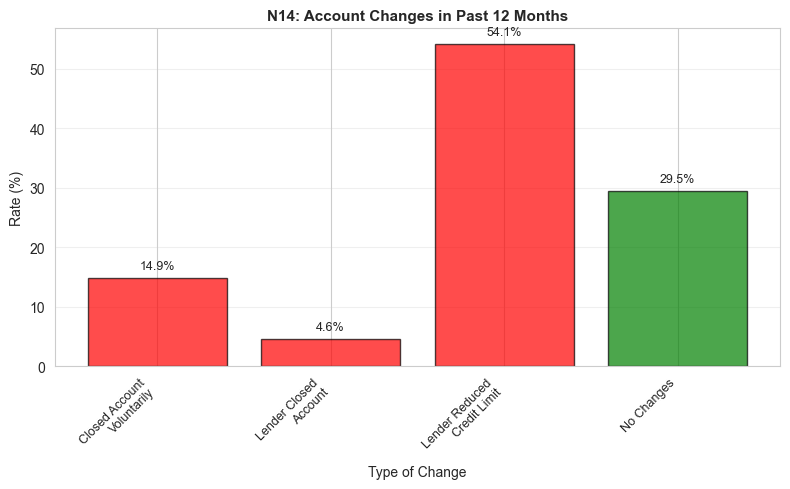

In [278]:
# N14: Changes to Existing Credit Accounts
print("="*80)
print("N14: ACCOUNT CHANGES (Past 12 Months)")
print("="*80)

account_changes = {
    'ClosedVoluntary': 'Closed Account\nVoluntarily',
    'ClosedByLender': 'Lender Closed\nAccount',
    'LimitReduced': 'Lender Reduced\nCredit Limit',
    'NoChanges': 'No Changes'
}

print("\nAccount change rates:")
change_rates = {}
for var, label in account_changes.items():
    if var in df_micro.columns:
        rate = df_micro[var].mean() * 100
        count = df_micro[var].sum()
        n = df_micro[var].notna().sum()
        print(f"  {label.replace(chr(10), ' '):40s}: {rate:>6.2f}% ({count:>7,} of {n:,})")
        change_rates[label] = rate

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
labels = list(change_rates.keys())
values = list(change_rates.values())
colors = ['red' if 'No Changes' not in lab else 'green' for lab in labels]
bars = ax.bar(range(len(labels)), values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Rate (%)', fontsize=10)
ax.set_xlabel('Type of Change', fontsize=10)
ax.set_title('N14: Account Changes in Past 12 Months', fontweight='bold', fontsize=11)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.1f}%', 
            ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

print("\n" + "="*80)

N15-N16: LATE PAYMENTS (Past 12 Months)

Late payment rates:
  Late >30 days:   6.53% (2,153.0 of 32,975)
  Late >90 days:  45.32% (  930.0 of 2,052)


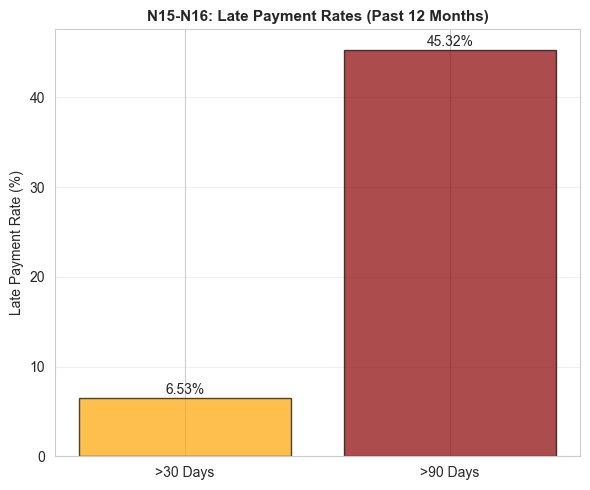

In [279]:
# N15-N16: Late Payments
print("="*80)
print("N15-N16: LATE PAYMENTS (Past 12 Months)")
print("="*80)

print("\nLate payment rates:")
late_data = {}
if 'Late30Days' in df_micro.columns:
    rate30 = df_micro['Late30Days'].mean() * 100
    count30 = df_micro['Late30Days'].sum()
    n30 = df_micro['Late30Days'].notna().sum()
    print(f"  Late >30 days: {rate30:>6.2f}% ({count30:>7,} of {n30:,})")
    late_data['>30 Days'] = rate30

if 'Late90Days' in df_micro.columns:
    rate90 = df_micro['Late90Days'].mean() * 100
    count90 = df_micro['Late90Days'].sum()
    n90 = df_micro['Late90Days'].notna().sum()
    print(f"  Late >90 days: {rate90:>6.2f}% ({count90:>7,} of {n90:,})")
    late_data['>90 Days'] = rate90

# Visualization
if len(late_data) > 0:
    fig, ax = plt.subplots(figsize=(6, 5))
    labels = list(late_data.keys())
    values = list(late_data.values())
    colors = ['orange', 'darkred']
    bars = ax.bar(labels, values, color=colors[:len(labels)], alpha=0.7, edgecolor='black')
    ax.set_ylabel('Late Payment Rate (%)', fontsize=10)
    ax.set_title('N15-N16: Late Payment Rates (Past 12 Months)', fontweight='bold', fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.1, f'{val:.2f}%', 
                ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)

N17random: INTENTION QUESTION FORMAT ASSIGNMENT

Total respondents: 22,533

Format assignment:
  Likert Scale (N17a)      :  11,144 ( 49.5%)
  Probability (N17b)       :  11,389 ( 50.5%)


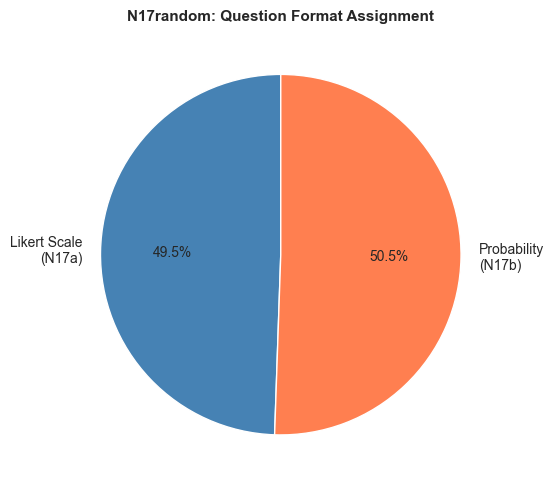

In [280]:
# N17random: Question Format Assignment
print("="*80)
print("N17random: INTENTION QUESTION FORMAT ASSIGNMENT")
print("="*80)

if 'IntentionQuestionFormat' in df_micro.columns:
    format_counts = df_micro['IntentionQuestionFormat'].value_counts().sort_index()
    total = format_counts.sum()
    print(f"\nTotal respondents: {total:,}")
    print("\nFormat assignment:")
    for fmt, count in format_counts.items():
        if fmt == 1:
            label = "Likert Scale (N17a)"
        elif fmt == 2:
            label = "Probability (N17b)"
        else:
            label = f"Format {fmt}"
        print(f"  {label:25s}: {count:>7,} ({100*count/total:>5.1f}%)")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(6, 5))
    labels_viz = ['Likert Scale\n(N17a)', 'Probability\n(N17b)']
    colors = ['steelblue', 'coral']
    ax.pie(format_counts, labels=labels_viz, autopct='%1.1f%%', colors=colors, startangle=90)
    ax.set_title('N17random: Question Format Assignment', fontweight='bold', fontsize=11)
    plt.tight_layout()
    plt.show()
else:
    print("\nVariable not found in dataset")

print("\n" + "="*80)

N17a: FUTURE CREDIT INTENTIONS - Likert Scale (1-5)

Credit Card:
  Mean: 1.69/5.0

Mortgage:
  Mean: 1.50/5.0

Auto Loan:
  Mean: 1.69/5.0

CC Limit Increase:
  Mean: 1.53/5.0

Loan Limit Increase:
  Mean: 1.39/5.0

Mortgage Refinance:
  Mean: 1.58/5.0

Student Loan:
  Mean: 1.25/5.0


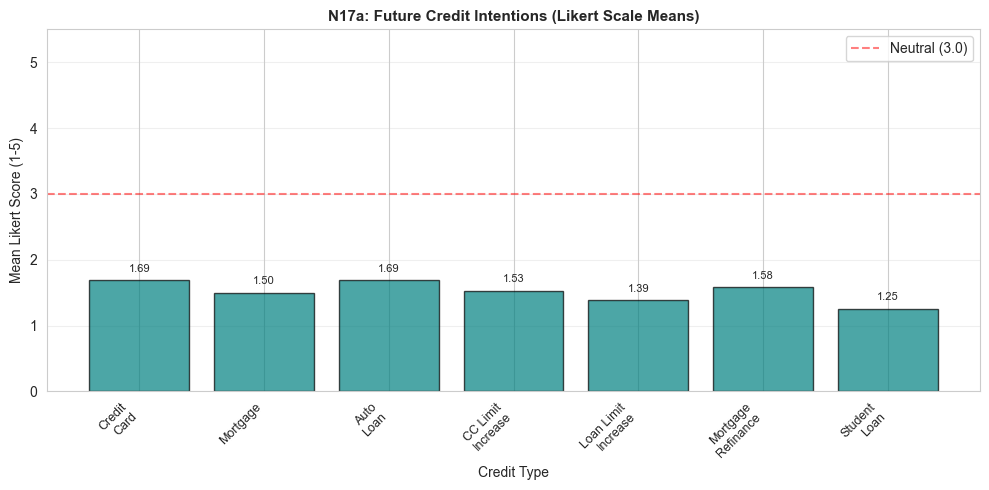

In [281]:
# N17a: Future Credit Intentions (Likert Scale)
print("="*80)
print("N17a: FUTURE CREDIT INTENTIONS - Likert Scale (1-5)")
print("="*80)

intention_vars = {
    'IntentionCC': 'Credit\nCard',
    'IntentionMortgage': 'Mortgage',
    'IntentionAuto': 'Auto\nLoan',
    'IntentionCCLimit': 'CC Limit\nIncrease',
    'IntentionLoanLimit': 'Loan Limit\nIncrease',
    'IntentionRefi': 'Mortgage\nRefinance',
    'IntentionStudent': 'Student\nLoan'
}

likert_labels = {1: 'Very Unlikely', 2: 'Somewhat Unlikely', 3: 'Neutral', 4: 'Somewhat Likely', 5: 'Very Likely'}

means = {}
for var, label in intention_vars.items():
    if var in df_micro.columns:
        counts = df_micro[var].value_counts().sort_index()
        if len(counts) > 0:
            total = counts.sum()
            mean_likert = df_micro[var].mean()
            means[label] = mean_likert
            print(f"\n{label.replace(chr(10), ' ')}:")
            print(f"  Mean: {mean_likert:.2f}/5.0")

# Visualization - Mean scores
fig, ax = plt.subplots(figsize=(10, 5))
labels = list(means.keys())
values = list(means.values())
bars = ax.bar(range(len(labels)), values, color='teal', alpha=0.7, edgecolor='black')
ax.set_ylabel('Mean Likert Score (1-5)', fontsize=10)
ax.set_xlabel('Credit Type', fontsize=10)
ax.set_title('N17a: Future Credit Intentions (Likert Scale Means)', fontweight='bold', fontsize=11)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax.set_ylim(0, 5.5)
ax.axhline(y=3, color='red', linestyle='--', alpha=0.5, label='Neutral (3.0)')
ax.grid(axis='y', alpha=0.3)
ax.legend()
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.1, f'{val:.2f}', 
            ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

print("\n" + "="*80)

N17b: FUTURE CREDIT INTENTIONS - Probability (0-100%)

Probability statistics (0-100 scale):
  Credit Card              : Mean  11.9%, Median   0.0% (n=33,103)
  Mortgage                 : Mean   8.0%, Median   0.0% (n=33,063)
  Auto Loan                : Mean  11.9%, Median   0.0% (n=33,076)
  CC Limit Increase        : Mean   7.0%, Median   0.0% (n=24,754)
  Loan Limit Increase      : Mean   3.8%, Median   0.0% (n=7,120)
  Mortgage Refinance       : Mean   8.8%, Median   0.0% (n=16,296)
  Student Loan             : Mean   3.9%, Median   0.0% (n=33,040)


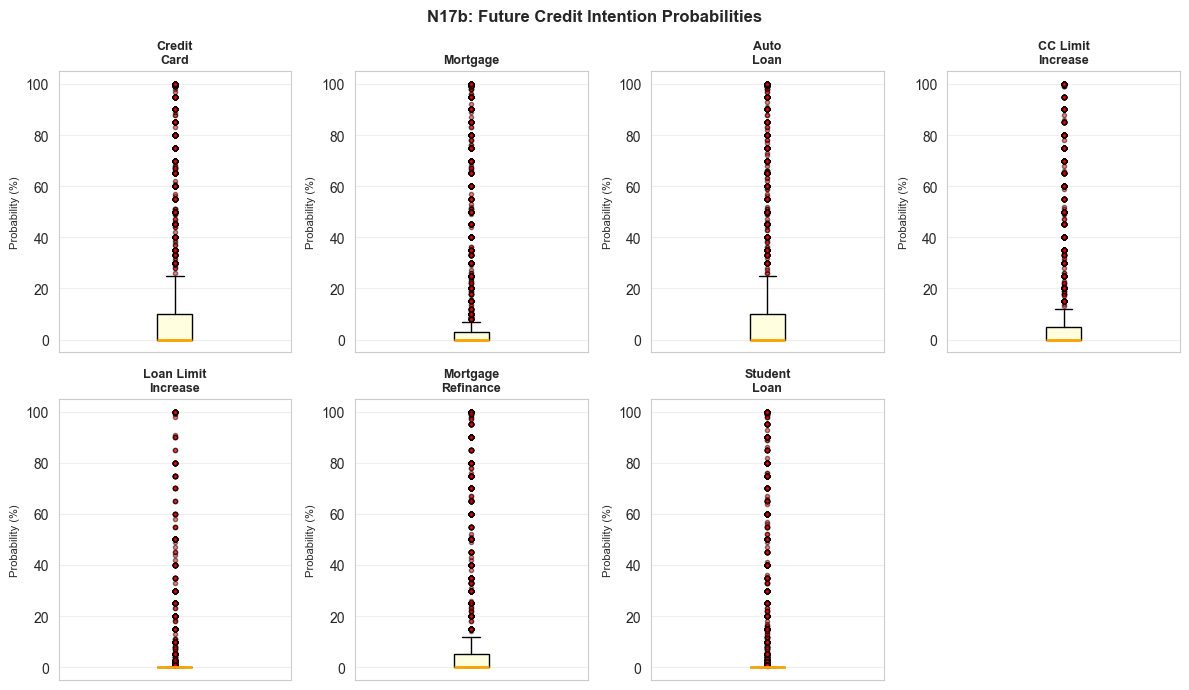

In [282]:
# N17b: Future Credit Intentions (Probability 0-100)
print("="*80)
print("N17b: FUTURE CREDIT INTENTIONS - Probability (0-100%)")
print("="*80)

prob_vars = {
    'ProbCC': 'Credit\nCard',
    'ProbMortgage': 'Mortgage',
    'ProbAuto': 'Auto\nLoan',
    'ProbCCLimit': 'CC Limit\nIncrease',
    'ProbLoanLimit': 'Loan Limit\nIncrease',
    'ProbRefi': 'Mortgage\nRefinance',
    'ProbStudent': 'Student\nLoan'
}

print("\nProbability statistics (0-100 scale):")
for var, label in prob_vars.items():
    if var in df_micro.columns:
        data = df_micro[var].dropna()
        if len(data) > 0:
            print(f"  {label.replace(chr(10), ' '):25s}: Mean {data.mean():>5.1f}%, Median {data.median():>5.1f}% (n={len(data):,})")

# Visualization - Box plots
fig, axes = plt.subplots(2, 4, figsize=(12, 7))
fig.suptitle('N17b: Future Credit Intention Probabilities', fontweight='bold', fontsize=12)
axes = axes.flatten()

for idx, (var, label) in enumerate(prob_vars.items()):
    ax = axes[idx]
    if var in df_micro.columns:
        data = df_micro[var].dropna()
        if len(data) > 10:
            bp = ax.boxplot(data, vert=True, patch_artist=True,
                           flierprops=dict(marker='o', markerfacecolor='red', markersize=3, alpha=0.5))
            bp['boxes'][0].set_facecolor('lightyellow')
            bp['medians'][0].set_color('orange')
            bp['medians'][0].set_linewidth(2)
            ax.set_ylabel('Probability (%)', fontsize=8)
            ax.set_title(label, fontsize=9, fontweight='bold')
            ax.set_ylim(-5, 105)
            ax.set_xticks([])
            ax.grid(axis='y', alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Insufficient\ndata', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(label, fontsize=9)

axes[7].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*80)

N18: REASONS FOR NO FUTURE APPLICATIONS (All items low)

Reasons for no future applications:
  Satisfied                               :  87.30% (10,937.0 of 12,528)
  Time Consuming                          :   2.63% ( 329.0 of 12,528)
  Don't Know How                          :   0.53% (  67.0 of 12,528)
  Rates Too High                          :   7.14% ( 894.0 of 12,528)
  Expected Denial                         :  10.46% (1,311.0 of 12,528)


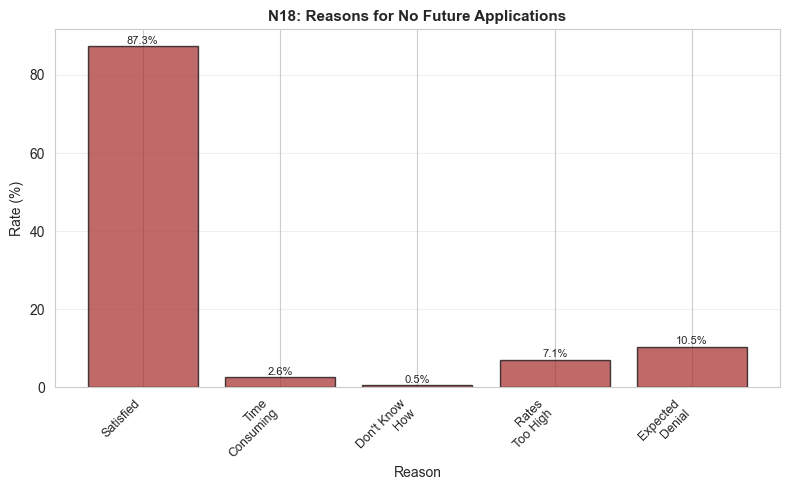

In [283]:
# N18: Reasons for No Future Credit Applications
print("="*80)
print("N18: REASONS FOR NO FUTURE APPLICATIONS (All items low)")
print("="*80)

n18_vars = {
    'NoIntentionNoNeed': 'Satisfied',
    'NoIntentionTimeConsuming': 'Time\nConsuming',
    'NoIntentionDontKnowHow': 'Don\'t Know\nHow',
    'NoIntentionRatesTooHigh': 'Rates\nToo High',
    'NoIntentionExpectedDenial': 'Expected\nDenial'
}

print("\nReasons for no future applications:")
n18_rates = {}
for var, label in n18_vars.items():
    if var in df_micro.columns:
        rate = df_micro[var].mean() * 100
        count = df_micro[var].sum()
        n = df_micro[var].notna().sum()
        print(f"  {label.replace(chr(10), ' '):40s}: {rate:>6.2f}% ({count:>6,} of {n:,})")
        n18_rates[label] = rate

# Visualization
if len(n18_rates) > 0:
    fig, ax = plt.subplots(figsize=(8, 5))
    labels = list(n18_rates.keys())
    values = list(n18_rates.values())
    bars = ax.bar(range(len(labels)), values, color='brown', alpha=0.7, edgecolor='black')
    ax.set_ylabel('Rate (%)', fontsize=10)
    ax.set_xlabel('Reason', fontsize=10)
    ax.set_title('N18: Reasons for No Future Applications', fontweight='bold', fontsize=11)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.1, f'{val:.1f}%', 
                ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)

N19: REASONS FOR LOW LIKELIHOOD (Specific Products)

Reasons for low likelihood (item-level):
  Satisfied                               :  86.98% (19,052.0 of 21,904)
  Time Consuming                          :   3.75% ( 822.0 of 21,904)
  Don't Know How                          :   1.00% ( 218.0 of 21,904)
  Rates Too High                          :  11.24% (2,462.0 of 21,904)
  Expected Denial                         :  10.82% (2,369.0 of 21,904)


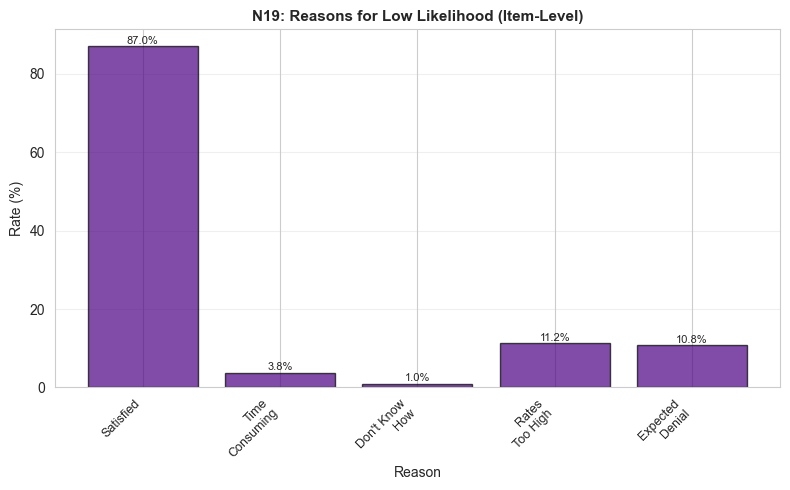

In [284]:
# N19: Reasons for Low Likelihood (Item-Level)
print("="*80)
print("N19: REASONS FOR LOW LIKELIHOOD (Specific Products)")
print("="*80)

n19_vars = {
    'LowLikelihoodNoNeed': 'Satisfied',
    'LowLikelihoodTimeConsuming': 'Time\nConsuming',
    'LowLikelihoodDontKnowHow': 'Don\'t Know\nHow',
    'LowLikelihoodRatesTooHigh': 'Rates\nToo High',
    'LowLikelihoodExpectedDenial': 'Expected\nDenial'
}

print("\nReasons for low likelihood (item-level):")
n19_rates = {}
for var, label in n19_vars.items():
    if var in df_micro.columns:
        rate = df_micro[var].mean() * 100
        count = df_micro[var].sum()
        n = df_micro[var].notna().sum()
        print(f"  {label.replace(chr(10), ' '):40s}: {rate:>6.2f}% ({count:>6,} of {n:,})")
        n19_rates[label] = rate

# Visualization
if len(n19_rates) > 0:
    fig, ax = plt.subplots(figsize=(8, 5))
    labels = list(n19_rates.keys())
    values = list(n19_rates.values())
    bars = ax.bar(range(len(labels)), values, color='indigo', alpha=0.7, edgecolor='black')
    ax.set_ylabel('Rate (%)', fontsize=10)
    ax.set_xlabel('Reason', fontsize=10)
    ax.set_title('N19: Reasons for Low Likelihood (Item-Level)', fontweight='bold', fontsize=11)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.1, f'{val:.1f}%', 
                ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)

N20: EXPECTED FUTURE DENIAL (Won't apply due to expected denial)

Expected denial rates:
  Credit Card              :  38.94% (  929.0 of 2,386)
  Mortgage                 :  26.92% (  777.0 of 2,886)
  Auto Loan                :  24.50% (  607.0 of 2,478)
  CC Limit Increase        :  28.63% (  461.0 of 1,610)
  Loan Limit Increase      :  19.32% (  194.0 of 1,004)
  Mortgage Refinance       :  29.13% (  229.0 of 786)
  Student Loan             :   4.97% (  144.0 of 2,896)
  None                     :  37.89% (1,261.0 of 3,328)


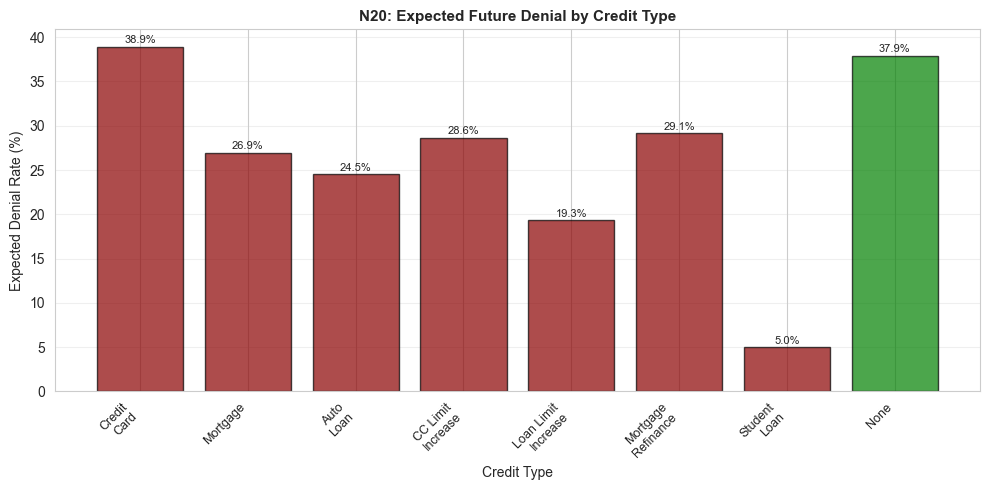

In [285]:
# N20: Expected Future Denial
print("="*80)
print("N20: EXPECTED FUTURE DENIAL (Won't apply due to expected denial)")
print("="*80)

n20_vars = {
    'ExpectDenialCC': 'Credit\nCard',
    'ExpectDenialMortgage': 'Mortgage',
    'ExpectDenialAuto': 'Auto\nLoan',
    'ExpectDenialCCLimit': 'CC Limit\nIncrease',
    'ExpectDenialLoanLimit': 'Loan Limit\nIncrease',
    'ExpectDenialRefi': 'Mortgage\nRefinance',
    'ExpectDenialStudent': 'Student\nLoan',
    'NoExpectedDenial': 'None'
}

print("\nExpected denial rates:")
n20_rates = {}
for var, label in n20_vars.items():
    if var in df_micro.columns:
        rate = df_micro[var].mean() * 100
        count = df_micro[var].sum()
        n = df_micro[var].notna().sum()
        print(f"  {label.replace(chr(10), ' '):25s}: {rate:>6.2f}% ({count:>7,} of {n:,})")
        n20_rates[label] = rate

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
labels = list(n20_rates.keys())
values = list(n20_rates.values())
colors = ['darkred' if 'None' not in lab else 'green' for lab in labels]
bars = ax.bar(range(len(labels)), values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Expected Denial Rate (%)', fontsize=10)
ax.set_xlabel('Credit Type', fontsize=10)
ax.set_title('N20: Expected Future Denial by Credit Type', fontweight='bold', fontsize=11)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.2, f'{val:.1f}%', 
            ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

print("\n" + "="*80)

N21: EXPECTED APPROVAL PROBABILITIES (If were to apply)

Expected approval probability (0-100% scale):
  Credit Card              : Mean  77.8%, Median  99.0% (n=15,963)
  Mortgage                 : Mean  68.0%, Median  80.0% (n=10,678)
  Auto Loan                : Mean  79.4%, Median  99.0% (n=14,903)
  CC Limit Increase        : Mean  67.2%, Median  80.0% (n=8,706)
  Loan Limit Increase      : Mean  53.1%, Median  50.0% (n=1,966)
  Mortgage Refinance       : Mean  74.9%, Median  90.0% (n=6,236)
  Student Loan             : Mean  66.5%, Median  90.0% (n=4,863)


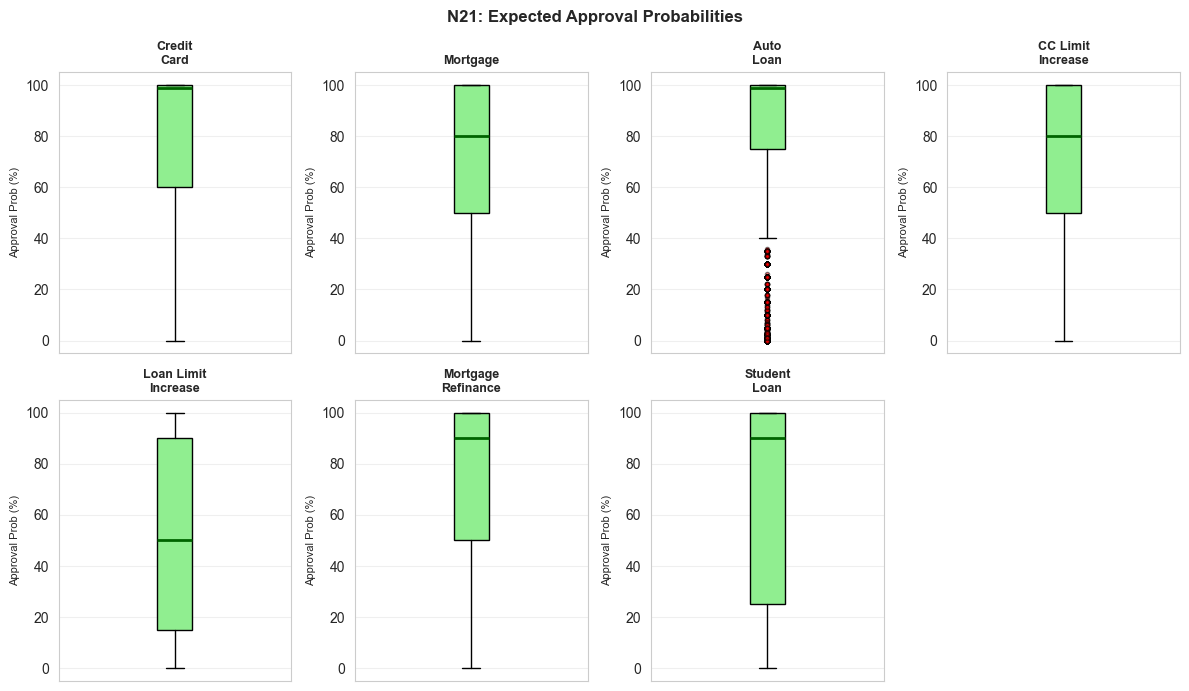

In [286]:
# N21: Expected Approval Probabilities
print("="*80)
print("N21: EXPECTED APPROVAL PROBABILITIES (If were to apply)")
print("="*80)

approval_vars = {
    'ApprovalProbCC': 'Credit\nCard',
    'ApprovalProbMortgage': 'Mortgage',
    'ApprovalProbAuto': 'Auto\nLoan',
    'ApprovalProbCCLimit': 'CC Limit\nIncrease',
    'ApprovalProbLoanLimit': 'Loan Limit\nIncrease',
    'ApprovalProbRefi': 'Mortgage\nRefinance',
    'ApprovalProbStudent': 'Student\nLoan'
}

print("\nExpected approval probability (0-100% scale):")
for var, label in approval_vars.items():
    if var in df_micro.columns:
        data = df_micro[var].dropna()
        if len(data) > 0:
            print(f"  {label.replace(chr(10), ' '):25s}: Mean {data.mean():>5.1f}%, Median {data.median():>5.1f}% (n={len(data):,})")

# Visualization - Box plots
fig, axes = plt.subplots(2, 4, figsize=(12, 7))
fig.suptitle('N21: Expected Approval Probabilities', fontweight='bold', fontsize=12)
axes = axes.flatten()

for idx, (var, label) in enumerate(approval_vars.items()):
    ax = axes[idx]
    if var in df_micro.columns:
        data = df_micro[var].dropna()
        if len(data) > 10:
            bp = ax.boxplot(data, vert=True, patch_artist=True,
                           flierprops=dict(marker='o', markerfacecolor='red', markersize=3, alpha=0.5))
            bp['boxes'][0].set_facecolor('lightgreen')
            bp['medians'][0].set_color('darkgreen')
            bp['medians'][0].set_linewidth(2)
            ax.set_ylabel('Approval Prob (%)', fontsize=8)
            ax.set_title(label, fontsize=9, fontweight='bold')
            ax.set_ylim(-5, 105)
            ax.set_xticks([])
            ax.grid(axis='y', alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Insufficient\ndata', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(label, fontsize=9)

axes[7].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*80)

N22: SELF-REPORTED CREDIT SCORE CATEGORY

Credit score distribution (n=34,828):
  Below 620      :   3,024 (  8.7%)
  620- 679       :   3,051 (  8.8%)
  680- 719       :   3,673 ( 10.5%)
  720- 760       :   6,605 ( 19.0%)
  Above 760      :  15,618 ( 44.8%)
  Don't Know     :   2,857 (  8.2%)


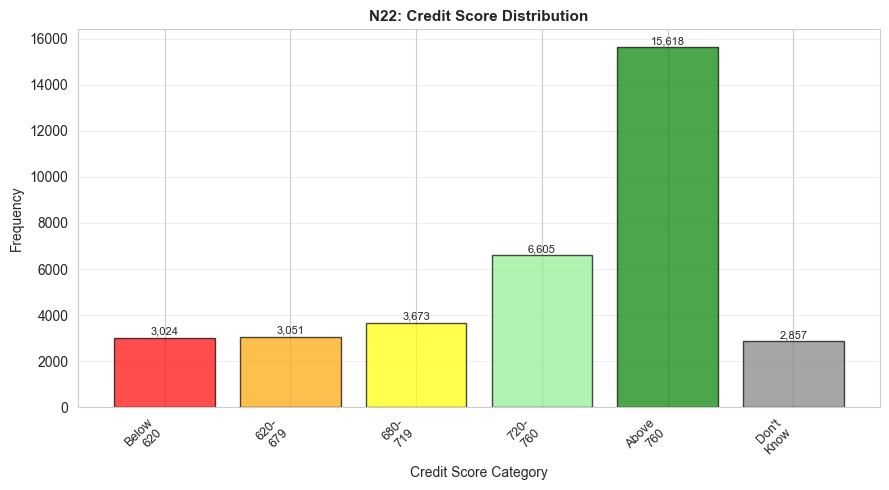

In [287]:
# N22: Self-Reported Credit Score
print("="*80)
print("N22: SELF-REPORTED CREDIT SCORE CATEGORY")
print("="*80)

if 'CreditScore' in df_micro.columns:
    score_labels = {
        1: 'Below\n620',
        2: '620-\n679',
        3: '680-\n719',
        4: '720-\n760',
        5: 'Above\n760',
        6: "Don't\nKnow"
    }
    
    counts = df_micro['CreditScore'].value_counts().sort_index()
    total = counts.sum()
    
    print(f"\nCredit score distribution (n={total:,}):")
    score_data = {}
    for score in sorted(counts.index):
        count = counts[score]
        label_print = score_labels.get(score, f'Code {score}').replace('\n', ' ')
        print(f"  {label_print:15s}: {count:>7,} ({100*count/total:>5.1f}%)")
        score_data[score] = count
    
    # Visualization
    fig, ax = plt.subplots(figsize=(9, 5))
    labels_viz = [score_labels.get(s, str(s)) for s in sorted(score_data.keys())]
    values = [score_data[s] for s in sorted(score_data.keys())]
    colors = ['red', 'orange', 'yellow', 'lightgreen', 'green', 'gray']
    bars = ax.bar(range(len(labels_viz)), values, color=colors[:len(labels_viz)], alpha=0.7, edgecolor='black')
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_xlabel('Credit Score Category', fontsize=10)
    ax.set_title('N22: Credit Score Distribution', fontweight='bold', fontsize=11)
    ax.set_xticks(range(len(labels_viz)))
    ax.set_xticklabels(labels_viz, rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, val + 50, f'{val:,}', 
                ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("\nVariable not found in dataset")

print("\n" + "="*80)

N23: LAST CREDIT SCORE CHECK

When last checked credit score (n=33,782):
  <1 month                      :  13,185 ( 39.0%)
  1-6 months                    :   7,973 ( 23.6%)
  6-12 months                   :   3,921 ( 11.6%)
  1-2 years                     :   3,616 ( 10.7%)
  >2 years                      :   3,454 ( 10.2%)
  Never                         :   1,633 (  4.8%)


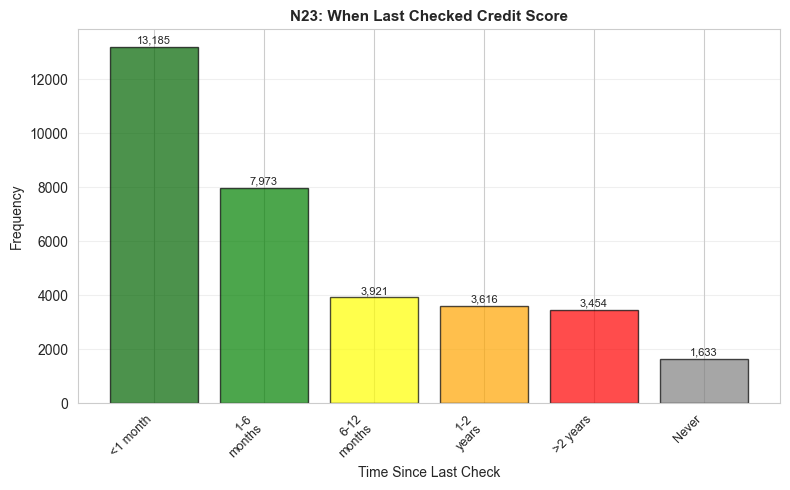

In [288]:
# N23: Last Credit Score Check
print("="*80)
print("N23: LAST CREDIT SCORE CHECK")
print("="*80)

if 'LastScoreCheck' in df_micro.columns:
    check_labels = {
        1: '<1 month',
        2: '1-6\nmonths',
        3: '6-12\nmonths',
        4: '1-2\nyears',
        5: '>2 years',
        6: 'Never'
    }
    
    counts = df_micro['LastScoreCheck'].value_counts().sort_index()
    total = counts.sum()
    
    print(f"\nWhen last checked credit score (n={total:,}):")
    check_data = {}
    for timing in sorted(counts.index):
        count = counts[timing]
        label_print = check_labels.get(timing, f'Code {timing}').replace('\n', ' ')
        print(f"  {label_print:30s}: {count:>7,} ({100*count/total:>5.1f}%)")
        check_data[timing] = count
    
    # Visualization
    fig, ax = plt.subplots(figsize=(8, 5))
    labels_viz = [check_labels.get(t, str(t)) for t in sorted(check_data.keys())]
    values = [check_data[t] for t in sorted(check_data.keys())]
    colors = ['darkgreen', 'green', 'yellow', 'orange', 'red', 'gray']
    bars = ax.bar(range(len(labels_viz)), values, color=colors[:len(labels_viz)], alpha=0.7, edgecolor='black')
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_xlabel('Time Since Last Check', fontsize=10)
    ax.set_title('N23: When Last Checked Credit Score', fontweight='bold', fontsize=11)
    ax.set_xticks(range(len(labels_viz)))
    ax.set_xticklabels(labels_viz, rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, val + 50, f'{val:,}', 
                ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("\nVariable not found in dataset")

print("\n" + "="*80)

N24-N25: EMERGENCY LIQUIDITY ($2,000 Need/Access)

Emergency liquidity probabilities (0-100% scale):

N24: Probability of needing $2,000 unexpectedly next month
  Mean:    35.0%
  Median:  30.0%
  Count:  29,257

N25: Probability of obtaining $2,000 within month if needed
  Mean:    73.3%
  Median:  97.0%
  Count:  29,251


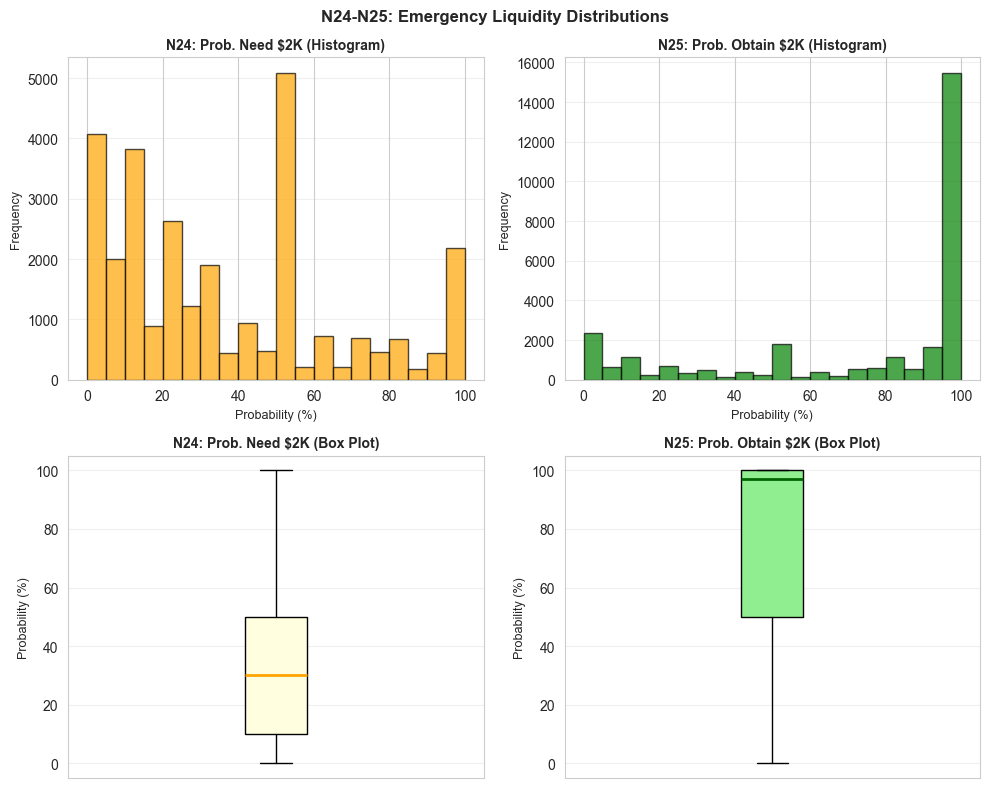


✅ UNIVARIATE ANALYSIS COMPLETE - All N1-N25 sections with visualizations


In [289]:
# N24-N25: Emergency Liquidity Needs
print("="*80)
print("N24-N25: EMERGENCY LIQUIDITY ($2,000 Need/Access)")
print("="*80)

print("\nEmergency liquidity probabilities (0-100% scale):")

liquidity_data = {}
if 'Need2000Prob' in df_micro.columns:
    data = df_micro['Need2000Prob'].dropna()
    if len(data) > 0:
        print(f"\nN24: Probability of needing $2,000 unexpectedly next month")
        print(f"  Mean:   {data.mean():>5.1f}%")
        print(f"  Median: {data.median():>5.1f}%")
        print(f"  Count:  {len(data):,}")
        liquidity_data['Need'] = data

if 'Obtain2000Prob' in df_micro.columns:
    data = df_micro['Obtain2000Prob'].dropna()
    if len(data) > 0:
        print(f"\nN25: Probability of obtaining $2,000 within month if needed")
        print(f"  Mean:   {data.mean():>5.1f}%")
        print(f"  Median: {data.median():>5.1f}%")
        print(f"  Count:  {len(data):,}")
        liquidity_data['Obtain'] = data

# Visualization
if len(liquidity_data) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle('N24-N25: Emergency Liquidity Distributions', fontweight='bold', fontsize=12)
    
    # Histogram for N24
    if 'Need' in liquidity_data:
        ax = axes[0, 0]
        ax.hist(liquidity_data['Need'], bins=20, color='orange', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Probability (%)', fontsize=9)
        ax.set_ylabel('Frequency', fontsize=9)
        ax.set_title('N24: Prob. Need $2K (Histogram)', fontsize=10, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Box plot for N24
        ax = axes[1, 0]
        bp = ax.boxplot(liquidity_data['Need'], vert=True, patch_artist=True,
                       flierprops=dict(marker='o', markerfacecolor='red', markersize=3, alpha=0.5))
        bp['boxes'][0].set_facecolor('lightyellow')
        bp['medians'][0].set_color('orange')
        bp['medians'][0].set_linewidth(2)
        ax.set_ylabel('Probability (%)', fontsize=9)
        ax.set_title('N24: Prob. Need $2K (Box Plot)', fontsize=10, fontweight='bold')
        ax.set_xticks([])
        ax.grid(axis='y', alpha=0.3)
    
    # Histogram for N25
    if 'Obtain' in liquidity_data:
        ax = axes[0, 1]
        ax.hist(liquidity_data['Obtain'], bins=20, color='green', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Probability (%)', fontsize=9)
        ax.set_ylabel('Frequency', fontsize=9)
        ax.set_title('N25: Prob. Obtain $2K (Histogram)', fontsize=10, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Box plot for N25
        ax = axes[1, 1]
        bp = ax.boxplot(liquidity_data['Obtain'], vert=True, patch_artist=True,
                       flierprops=dict(marker='o', markerfacecolor='red', markersize=3, alpha=0.5))
        bp['boxes'][0].set_facecolor('lightgreen')
        bp['medians'][0].set_color('darkgreen')
        bp['medians'][0].set_linewidth(2)
        ax.set_ylabel('Probability (%)', fontsize=9)
        ax.set_title('N25: Prob. Obtain $2K (Box Plot)', fontsize=10, fontweight='bold')
        ax.set_xticks([])
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("✅ UNIVARIATE ANALYSIS COMPLETE - All N1-N25 sections with visualizations")
print("="*80)

---
## 5. Bivariate Analysis & Visualizations

Examine relationships between key variables.

In [290]:
# Comprehensive Bivariate Statistical Analysis
print("="*80)
print("COMPREHENSIVE BIVARIATE ANALYSIS")
print("Testing all pairwise relationships between survey variables")
print("Significance threshold: p < 0.01")
print("="*80)

from scipy import stats
from scipy.stats import chi2_contingency, pearsonr, spearmanr, f_oneway
import warnings
warnings.filterwarnings('ignore')

# Define all survey variables by type
continuous_vars = [
    'CCBalance', 'MortgageBalance', 'StudentBalance', 'HomeBalance', 'AutoBalance', 'OtherBalance',
    'AmountAppliedCC', 'AmountAppliedMortgage', 'AmountAppliedAuto', 'AmountAppliedStudent',
    'AmountRequestedRefi',
    'ProbCC', 'ProbMortgage', 'ProbAuto', 'ProbCCLimit', 'ProbLoanLimit', 'ProbRefi', 'ProbStudent',
    'ApprovalProbCC', 'ApprovalProbMortgage', 'ApprovalProbAuto', 'ApprovalProbCCLimit',
    'ApprovalProbLoanLimit', 'ApprovalProbRefi', 'ApprovalProbStudent',
    'Need2000Prob', 'Obtain2000Prob'
]

binary_vars = [
    'HasCreditCard', 'HasMortgage', 'HasStudentLoan', 'HasHomeLoan', 'HasAutoLoan', 'HasOtherLoan', 'HasNoDebt',
    'MaxedOutCC',
    'AppliedCC', 'AppliedMortgage', 'AppliedAuto', 'RequestedCCLimit', 'RequestedLoanLimit', 
    'RequestedRefi', 'AppliedStudent',
    'NoNeed', 'TooTimeConsuming', 'RatesTooHigh', 'DontKnowHow', 'ExpectedDenial',
    'DiscouragedCC', 'DiscouragedMortgage', 'DiscouragedAuto', 'DiscouragedCCLimit',
    'DiscouragedLoanLimit', 'DiscouragedRefi', 'DiscouragedStudent', 'NotDiscouraged',
    'ClosedVoluntary', 'ClosedByLender', 'LimitReduced', 'NoChanges',
    'Late30Days', 'Late90Days',
    'NoIntentionNoNeed', 'NoIntentionTimeConsuming', 'NoIntentionDontKnowHow',
    'NoIntentionRatesTooHigh', 'NoIntentionExpectedDenial',
    'LowLikelihoodNoNeed', 'LowLikelihoodTimeConsuming', 'LowLikelihoodDontKnowHow',
    'LowLikelihoodRatesTooHigh', 'LowLikelihoodExpectedDenial',
    'ExpectDenialCC', 'ExpectDenialMortgage', 'ExpectDenialAuto', 'ExpectDenialCCLimit',
    'ExpectDenialLoanLimit', 'ExpectDenialRefi', 'ExpectDenialStudent', 'NoExpectedDenial'
]

ordinal_vars = [
    'CCBalanceCat', 'MortgageBalanceCat', 'StudentBalanceCat', 'HomeBalanceCat', 'AutoBalanceCat', 'OtherBalanceCat',
    'OutcomeCC', 'OutcomeMortgage', 'OutcomeAuto', 'OutcomeCCLimit', 'OutcomeLoanLimit', 'OutcomeStudent',
    'RefiApproved',
    'IntentionCC', 'IntentionMortgage', 'IntentionAuto', 'IntentionCCLimit', 'IntentionLoanLimit',
    'IntentionRefi', 'IntentionStudent',
    'CreditScore', 'LastScoreCheck', 'IntentionQuestionFormat'
]

# Filter to only include variables that exist in the dataframe
continuous_vars = [v for v in continuous_vars if v in df_micro.columns]
binary_vars = [v for v in binary_vars if v in df_micro.columns]
ordinal_vars = [v for v in ordinal_vars if v in df_micro.columns]

all_vars = continuous_vars + binary_vars + ordinal_vars

print(f"\nAnalyzing {len(all_vars)} survey variables:")
print(f"  - {len(continuous_vars)} continuous variables")
print(f"  - {len(binary_vars)} binary categorical variables")
print(f"  - {len(ordinal_vars)} ordinal categorical variables")
print(f"\nTotal pairwise comparisons: {len(all_vars) * (len(all_vars) - 1) // 2:,}")
print("\nRunning statistical tests... (this may take a few minutes)")

# Store results - use set to track unique pairs
results = []
tested_pairs = set()  # Track tested pairs to avoid duplicates

def calculate_effect_size(var1, var2, data1, data2, test_type):
    """Calculate appropriate effect size measure"""
    if test_type == 'pearson' or test_type == 'spearman':
        # For correlations, r is already the effect size, r² is variance explained
        corr, _ = pearsonr(data1, data2) if test_type == 'pearson' else spearmanr(data1, data2)
        return corr ** 2
    elif test_type == 'chi2':
        # For chi-square, use Cramér's V
        contingency = pd.crosstab(data1, data2)
        chi2, _, _, _ = chi2_contingency(contingency)
        n = len(data1)
        min_dim = min(contingency.shape[0], contingency.shape[1]) - 1
        cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
        return cramers_v ** 2  # Return V² for consistency with R²
    elif test_type == 'anova' or test_type == 'ttest':
        # For ANOVA/t-test, use eta-squared
        groups = [data2[data1 == cat].dropna() for cat in data1.dropna().unique()]
        groups = [g for g in groups if len(g) > 0]
        if len(groups) < 2:
            return 0
        
        # Calculate eta-squared: SS_between / SS_total
        grand_mean = data2.mean()
        ss_between = sum([len(g) * (g.mean() - grand_mean)**2 for g in groups])
        ss_total = sum([(x - grand_mean)**2 for x in data2.dropna()])
        eta_sq = ss_between / ss_total if ss_total > 0 else 0
        return eta_sq
    return 0

# Test all pairwise relationships
total_tests = len(all_vars) * (len(all_vars) - 1) // 2
test_count = 0
print_interval = max(1, total_tests // 20)  # Print progress every 5%

for i, var1 in enumerate(all_vars):
    for var2 in all_vars[i+1:]:
        test_count += 1
        if test_count % print_interval == 0:
            progress = 100 * test_count / total_tests
            print(f"Progress: {progress:.0f}% ({test_count:,} / {total_tests:,} tests)", end='\r')
        
        # Create canonical pair key (alphabetically sorted to avoid duplicates)
        pair_key = tuple(sorted([var1, var2]))
        if pair_key in tested_pairs:
            continue
        tested_pairs.add(pair_key)
        
        try:
            # Get data
            data1 = df_micro[var1].dropna()
            data2 = df_micro[var2].dropna()
            
            # Need common indices
            common_idx = data1.index.intersection(data2.index)
            if len(common_idx) < 30:  # Minimum sample size
                continue
            
            data1_original = df_micro.loc[common_idx, var1]
            data2_original = df_micro.loc[common_idx, var2]
            
            # Keep track of original variable order
            var1_original = var1
            var2_original = var2
            data1 = data1_original.copy()
            data2 = data2_original.copy()
            
            # Determine test type based on variable types
            var1_type = 'continuous' if var1 in continuous_vars else ('binary' if var1 in binary_vars else 'ordinal')
            var2_type = 'continuous' if var2 in continuous_vars else ('binary' if var2 in binary_vars else 'ordinal')
            
            p_value = None
            test_type = None
            
            # Continuous vs Continuous: Pearson correlation
            if var1_type == 'continuous' and var2_type == 'continuous':
                corr, p = pearsonr(data1, data2)
                p_value = p
                test_type = 'pearson'
            
            # Continuous vs Categorical: ANOVA or t-test
            elif (var1_type == 'continuous' and var2_type in ['binary', 'ordinal']) or                  (var2_type == 'continuous' and var1_type in ['binary', 'ordinal']):
                # Swap DATA ONLY if needed so categorical is first, but keep original variable names
                if var1_type == 'continuous':
                    data1, data2 = data2_original.copy(), data1_original.copy()
                
                groups = [data2[data1 == cat].dropna() for cat in data1.unique()]
                groups = [g for g in groups if len(g) > 0]
                
                if len(groups) >= 2:
                    if len(groups) == 2:
                        # t-test
                        stat, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
                        p_value = p
                        test_type = 'ttest'
                    else:
                        # ANOVA
                        stat, p = f_oneway(*groups)
                        p_value = p
                        test_type = 'anova'
            
            # Categorical vs Categorical: Chi-square
            elif var1_type in ['binary', 'ordinal'] and var2_type in ['binary', 'ordinal']:
                contingency = pd.crosstab(data1, data2)
                if contingency.size > 1:  # Need at least 2 cells
                    chi2, p, dof, expected = chi2_contingency(contingency)
                    p_value = p
                    test_type = 'chi2'
            
            # Store significant results (p < 0.01 now)
            if p_value is not None and p_value < 0.01:
                effect_size = calculate_effect_size(var1_original, var2_original, data1, data2, test_type)
                results.append({
                    'var1': var1_original,
                    'var2': var2_original,
                    'p_value': p_value,
                    'effect_size': effect_size,
                    'test_type': test_type,
                    'n': len(common_idx)
                })
        
        except Exception as e:
            # Skip problematic pairs
            pass

print(f"\nProgress: 100% ({total_tests:,} / {total_tests:,} tests)      ")
print(f"\nFound {len(results):,} statistically significant relationships (p < 0.01)")
print(f"Unique pairs tested: {len(tested_pairs):,}")
print("="*80)


COMPREHENSIVE BIVARIATE ANALYSIS
Testing all pairwise relationships between survey variables
Significance threshold: p < 0.01

Analyzing 97 survey variables:
  - 22 continuous variables
  - 52 binary categorical variables
  - 23 ordinal categorical variables

Total pairwise comparisons: 4,656

Running statistical tests... (this may take a few minutes)
Progress: 100% (4,640 / 4,656 tests)
Progress: 100% (4,656 / 4,656 tests)      

Found 1,960 statistically significant relationships (p < 0.01)
Unique pairs tested: 4,656


In [291]:
# Display All Significant Relationships Sorted by P-Value
print("="*80)
print("ALL SIGNIFICANT RELATIONSHIPS (p < 0.01)")
print("Sorted by p-value (most significant first)")
print("="*80)

# Sort by p-value
results_sorted = sorted(results, key=lambda x: x['p_value'])

print(f"\nShowing all {len(results_sorted):,} significant relationships:\n")
print(f"{'#':>4}  {'Variable 1':25s}  {'<->':3s}  {'Variable 2':25s}  {'P-Value':12s}  {'R²/V²/η²':10s}  {'Test':10s}  {'N':>8s}")
print("-" * 120)

test_labels = {
    'pearson': 'Pearson',
    'spearman': 'Spearman',
    'chi2': 'Chi-Square',
    'anova': 'ANOVA',
    'ttest': 'T-Test'
}

for i, result in enumerate(results_sorted, 1):
    var1 = result['var1']
    var2 = result['var2']
    p_val = result['p_value']
    effect = result['effect_size']
    test = test_labels.get(result['test_type'], result['test_type'])
    n = result['n']
    
    # Format p-value
    if p_val < 0.0001:
        p_str = "< 0.0001"
    else:
        p_str = f"{p_val:.4f}"
    
    print(f"{i:4d}  {var1:25s}  <->  {var2:25s}  p={p_str:10s}  {effect:8.4f}    {test:10s}  {n:8,d}")

print("\n" + "="*80)
print("Legend:")
print("  <-> = Statistically associated (correlation does not imply causation)")
print("  R² = Coefficient of determination (for correlations)")
print("  V² = Cramér's V squared (for chi-square tests)")
print("  η² = Eta-squared (for ANOVA/t-tests)")
print("\nSignificance: All relationships shown have p < 0.01")
print("="*80)


ALL SIGNIFICANT RELATIONSHIPS (p < 0.01)
Sorted by p-value (most significant first)

Showing all 1,960 significant relationships:

   #  Variable 1                 <->  Variable 2                 P-Value       R²/V²/η²    Test               N
------------------------------------------------------------------------------------------------------------------------
   1  CCBalance                  <->  AutoBalance                p=< 0.0001      0.2388    Pearson       11,637
   2  StudentBalance             <->  AutoBalance                p=< 0.0001      0.8322    Pearson        4,409
   3  ProbCC                     <->  ProbCCLimit                p=< 0.0001      0.1874    Pearson       24,745
   4  ProbCC                     <->  AppliedCC                  p=< 0.0001      0.0756    T-Test        33,086
   5  ProbCC                     <->  IntentionCC                p=< 0.0001      0.5222    ANOVA         31,403
   6  ProbCC                     <->  IntentionCCLimit           p=< 0.0001 

In [292]:
# Display Top 10 Relationships by Effect Size (R²)
print("="*80)
print("TOP 10 STATISTICALLY SIGNIFICANT RELATIONSHIPS BY EFFECT SIZE")
print("Sorted by R² / V² / η² (variance explained)")
print("Significance threshold: p < 0.01")
print("="*80)

# Sort by effect size
results_by_effect = sorted(results, key=lambda x: abs(x['effect_size']), reverse=True)

print(f"\nShowing top 10 relationships by effect size:\n")
print(f"{'Rank':>4}  {'Variable 1':25s}  {'<->':3s}  {'Variable 2':25s}  {'R²/V²/η²':10s}  {'P-Value':12s}  {'Test':10s}  {'N':>8s}")
print("-" * 120)

test_labels = {
    'pearson': 'Pearson',
    'spearman': 'Spearman', 
    'chi2': 'Chi-Square',
    'anova': 'ANOVA',
    'ttest': 'T-Test'
}

for i, result in enumerate(results_by_effect[:10], 1):
    var1 = result['var1']
    var2 = result['var2']
    p_val = result['p_value']
    effect = result['effect_size']
    test = test_labels.get(result['test_type'], result['test_type'])
    n = result['n']
    
    # Format p-value
    if p_val < 0.0001:
        p_str = "< 0.0001"
    else:
        p_str = f"{p_val:.4f}"
    
    print(f"{i:4d}  {var1:25s}  <->  {var2:25s}  {effect:8.4f}    p={p_str:10s}  {test:10s}  {n:8,d}")

print("\n" + "="*80)
print("Interpretation:")
print("  - Effect sizes > 0.14 are considered 'large' effects")
print("  - Effect sizes 0.06-0.14 are 'medium' effects")
print("  - Effect sizes < 0.06 are 'small' effects")
print("  - These represent the proportion of variance in one variable explained by another")
print("  - All relationships shown have p < 0.01")
print("="*80)


TOP 10 STATISTICALLY SIGNIFICANT RELATIONSHIPS BY EFFECT SIZE
Sorted by R² / V² / η² (variance explained)
Significance threshold: p < 0.01

Showing top 10 relationships by effect size:

Rank  Variable 1                 <->  Variable 2                 R²/V²/η²    P-Value       Test               N
------------------------------------------------------------------------------------------------------------------------
   1  StudentBalance             <->  AutoBalance                  0.8322    p=< 0.0001    Pearson        4,409
   2  ApprovalProbCC             <->  ApprovalProbAuto             0.7340    p=< 0.0001    Pearson        9,890
   3  NoNeed                     <->  NoIntentionNoNeed            0.7203    p=< 0.0001    Chi-Square     8,182
   4  ApprovalProbMortgage       <->  ApprovalProbRefi             0.7099    p=< 0.0001    Pearson        3,554
   5  ApprovalProbCCLimit        <->  ApprovalProbLoanLimit        0.7090    p=< 0.0001    Pearson        1,489
   6  ApprovalProbMor

VISUALIZING TOP 5 RELATIONSHIPS BY EFFECT SIZE


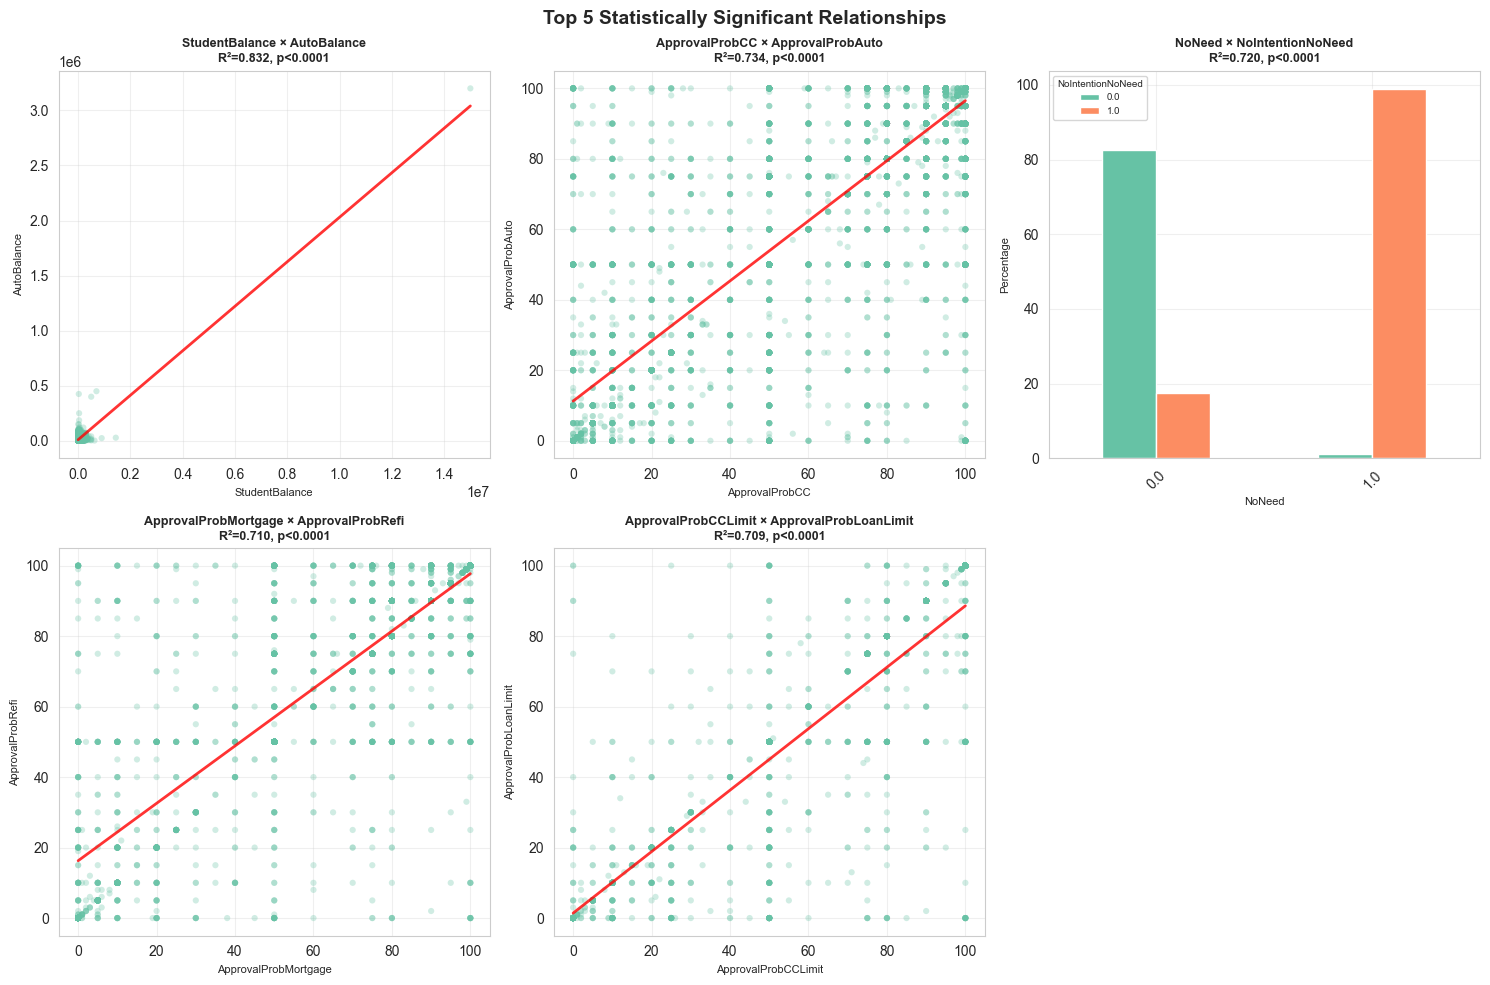


✓ Bivariate analysis complete


In [293]:
# Visualize Top 5 Relationships
print("="*80)
print("VISUALIZING TOP 5 RELATIONSHIPS BY EFFECT SIZE")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Top 5 Statistically Significant Relationships', fontsize=14, fontweight='bold')
axes = axes.flatten()

for i, result in enumerate(results_by_effect[:5]):
    ax = axes[i]
    var1 = result['var1']
    var2 = result['var2']
    effect = result['effect_size']
    p_val = result['p_value']
    test = result['test_type']
    
    # Get data
    common_idx = df_micro[var1].dropna().index.intersection(df_micro[var2].dropna().index)
    data1 = df_micro.loc[common_idx, var1]
    data2 = df_micro.loc[common_idx, var2]
    
    # Create appropriate visualization
    if test == 'pearson' or test == 'spearman':
        # Scatter plot for continuous variables
        ax.scatter(data1, data2, alpha=0.3, s=20, edgecolors='none')
        ax.set_xlabel(var1, fontsize=8)
        ax.set_ylabel(var2, fontsize=8)
        
        # Add regression line
        z = np.polyfit(data1, data2, 1)
        p = np.poly1d(z)
        x_line = np.linspace(data1.min(), data1.max(), 100)
        ax.plot(x_line, p(x_line), "r-", alpha=0.8, linewidth=2)
        
    elif test == 'chi2':
        # Grouped bar chart for categorical variables
        contingency = pd.crosstab(data1, data2, normalize='index') * 100
        contingency.plot(kind='bar', ax=ax, rot=45)
        ax.set_xlabel(var1, fontsize=8)
        ax.set_ylabel('Percentage', fontsize=8)
        ax.legend(title=var2, fontsize=7, title_fontsize=7, loc='best')
        
    elif test == 'anova' or test == 'ttest':
        # Box plot for continuous vs categorical
        categories = sorted(data1.unique())
        box_data = [data2[data1 == cat].dropna() for cat in categories]
        bp = ax.boxplot(box_data, labels=categories, patch_artist=True,
                       flierprops=dict(marker='o', markerfacecolor='red', markersize=3, alpha=0.5))
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
        ax.set_xlabel(var1, fontsize=8)
        ax.set_ylabel(var2, fontsize=8)
        ax.tick_params(axis='x', rotation=45, labelsize=7)
    
    # Title with stats
    p_str = f"p<0.0001" if p_val < 0.0001 else f"p={p_val:.4f}"
    ax.set_title(f"{var1} × {var2}\nR²={effect:.3f}, {p_str}", fontsize=9, fontweight='bold')
    ax.grid(alpha=0.3)

# Hide the 6th subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Bivariate analysis complete")
print("="*80)


---
## 6. Time Series Analysis

Analyze trends over survey waves using aggregate data.

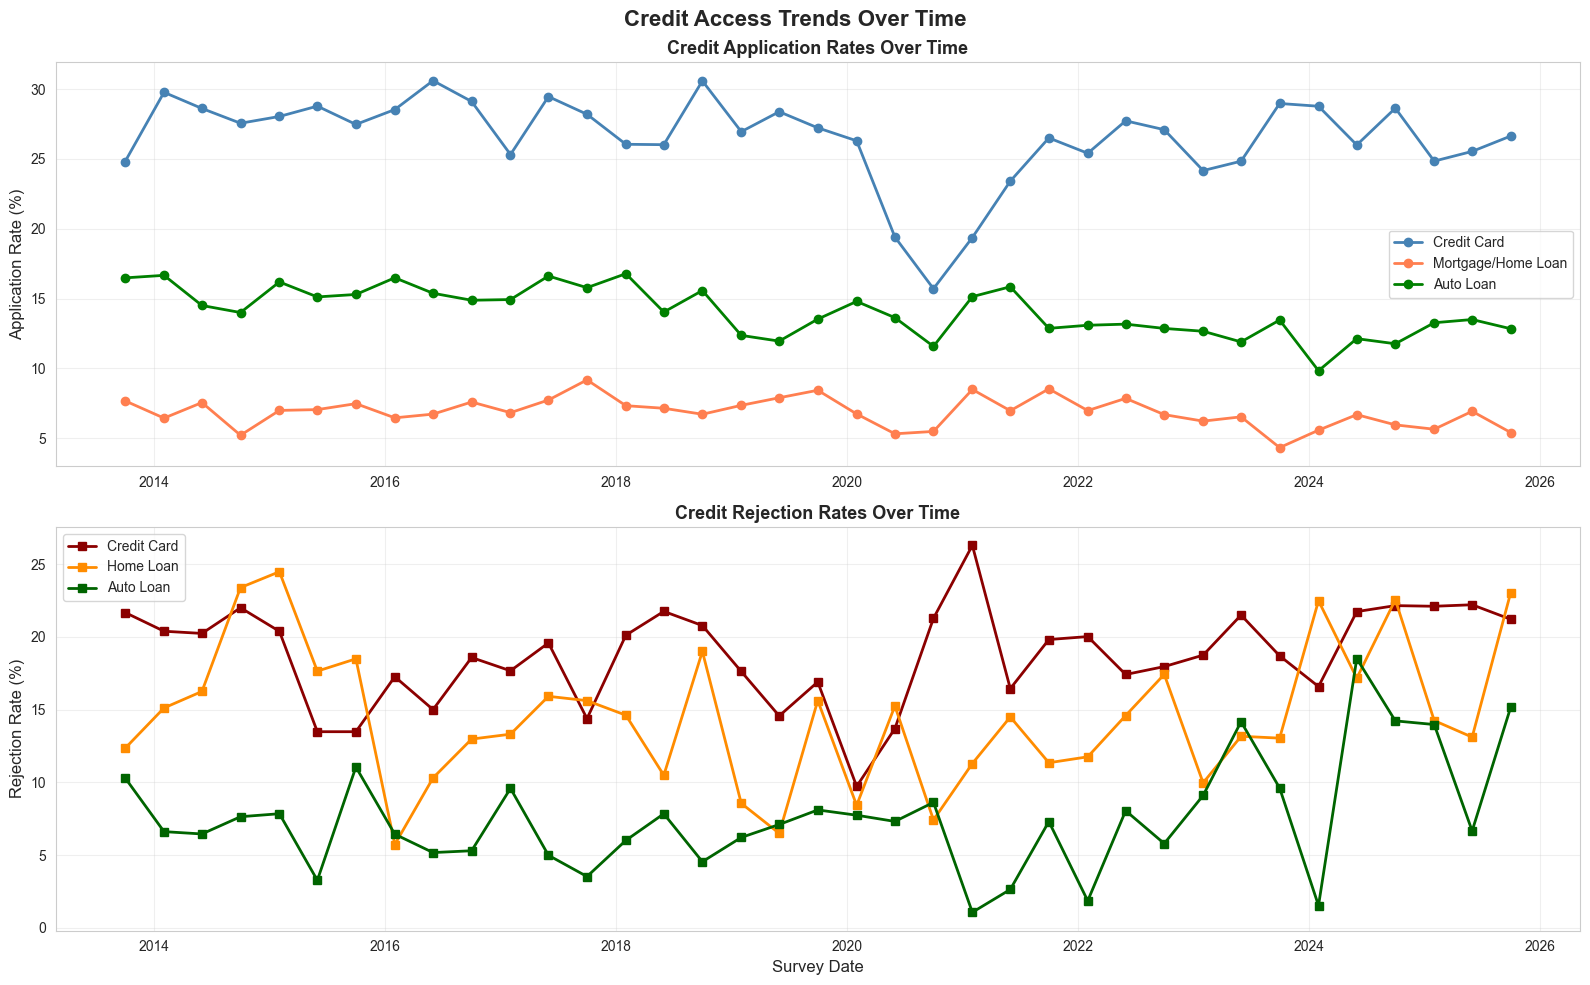

✓ Time series trends visualization complete


In [294]:
# 6.1 Application and Rejection Trends Over Time
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle('Credit Access Trends Over Time', fontsize=16, fontweight='bold')

# Plot 1: Application rates
ax1 = axes[0]
if 'date' in df_overall.columns:
    # Convert date to datetime for better plotting
    df_overall['date_fmt'] = pd.to_datetime(df_overall['date'].astype(str), format='%Y%m')
    
    app_cols = ['AppliedforCreditCard', 'AppliedforMortage_Home-BasedLoan', 'AppliedforAutoLoan']
    labels = ['Credit Card', 'Mortgage/Home Loan', 'Auto Loan']
    colors = ['steelblue', 'coral', 'green']
    
    for col, label, color in zip(app_cols, labels, colors):
        if col in df_overall.columns:
            ax1.plot(df_overall['date_fmt'], df_overall[col], marker='o', label=label, color=color, linewidth=2)
    
    ax1.set_ylabel('Application Rate (%)', fontsize=12)
    ax1.set_title('Credit Application Rates Over Time', fontweight='bold', fontsize=13)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(alpha=0.3)

# Plot 2: Rejection rates
ax2 = axes[1]
rej_cols = ['CCRejected', 'HomeLoanRejected', 'AutoLoanRejected']
labels = ['Credit Card', 'Home Loan', 'Auto Loan']
colors = ['darkred', 'darkorange', 'darkgreen']

for col, label, color in zip(rej_cols, labels, colors):
    if col in df_overall.columns:
        ax2.plot(df_overall['date_fmt'], df_overall[col], marker='s', label=label, color=color, linewidth=2)

ax2.set_ylabel('Rejection Rate (%)', fontsize=12)
ax2.set_xlabel('Survey Date', fontsize=12)
ax2.set_title('Credit Rejection Rates Over Time', fontweight='bold', fontsize=13)
ax2.legend(loc='best', fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Time series trends visualization complete")

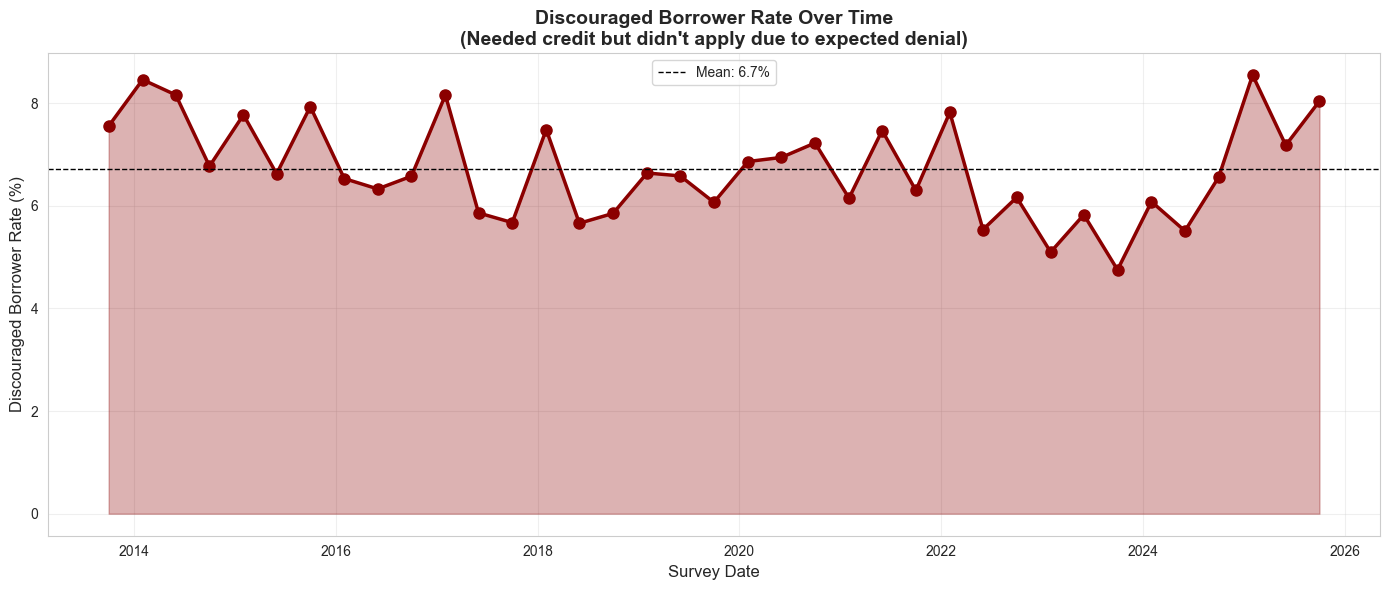

✓ Discouraged borrower trend visualization complete
  Average discouraged rate: 6.72%
  Range: 4.75% - 8.55%


In [295]:
# 6.2 Discouraged Borrower Rate Over Time
if 'Discouraged' in df_overall.columns:
    plt.figure(figsize=(14, 6))
    plt.plot(df_overall['date_fmt'], df_overall['Discouraged'], 
             marker='o', color='darkred', linewidth=2.5, markersize=8)
    plt.fill_between(df_overall['date_fmt'], df_overall['Discouraged'], alpha=0.3, color='darkred')
    
    plt.ylabel('Discouraged Borrower Rate (%)', fontsize=12)
    plt.xlabel('Survey Date', fontsize=12)
    plt.title('Discouraged Borrower Rate Over Time\n(Needed credit but didn\'t apply due to expected denial)', 
              fontweight='bold', fontsize=14)
    plt.grid(alpha=0.3)
    
    # Add mean line
    mean_discouraged = df_overall['Discouraged'].mean()
    plt.axhline(y=mean_discouraged, color='black', linestyle='--', linewidth=1, label=f'Mean: {mean_discouraged:.1f}%')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Discouraged borrower trend visualization complete")
    print(f"  Average discouraged rate: {mean_discouraged:.2f}%")
    print(f"  Range: {df_overall['Discouraged'].min():.2f}% - {df_overall['Discouraged'].max():.2f}%")
else:
    print("Discouraged variable not found in aggregate data")

---
## 7. Demographic Analysis

Compare credit access patterns across demographic groups.

In [296]:
# 7.1 Credit Access by Demographics
print("="*80)
print("CREDIT ACCESS BY DEMOGRAPHIC GROUPS")
print("="*80)

if 'group' in df_demographics.columns:
    # Get latest survey wave for snapshot
    latest_date = df_demographics['date'].max()
    df_latest = df_demographics[df_demographics['date'] == latest_date]
    
    # Group by demographic category
    demographic_groups = df_latest['group'].unique()
    
    print(f"\nLatest survey wave: {latest_date}")
    print(f"Demographic groups available: {', '.join(demographic_groups)}")
    
    # Application rates by credit score
    if 'credit_score' in demographic_groups:
        print("\n📊 APPLICATION RATES BY CREDIT SCORE")
        print("-"*80)
        credit_score_data = df_latest[df_latest['group'] == 'credit_score']
        
        if 'Appliedforoneormoretypesofcredit' in credit_score_data.columns:
            for idx, row in credit_score_data.iterrows():
                category = row.get('category', 'Unknown')
                app_rate = row['Appliedforoneormoretypesofcredit']
                print(f"  {category:20s}: {app_rate:>6.2f}% applied")
        
        print("\n😞 DISCOURAGED BORROWER RATES BY CREDIT SCORE")
        print("-"*80)
        if 'Discouraged' in credit_score_data.columns:
            for idx, row in credit_score_data.iterrows():
                category = row.get('category', 'Unknown')
                disc_rate = row['Discouraged']
                print(f"  {category:20s}: {disc_rate:>6.2f}% discouraged")

print("\n" + "="*80)

CREDIT ACCESS BY DEMOGRAPHIC GROUPS

Latest survey wave: 202510
Demographic groups available: credit_score, age

📊 APPLICATION RATES BY CREDIT SCORE
--------------------------------------------------------------------------------
  less_680            :  51.71% applied
  between_680_760     :  50.22% applied
  over_760            :  35.79% applied

😞 DISCOURAGED BORROWER RATES BY CREDIT SCORE
--------------------------------------------------------------------------------
  less_680            :  27.77% discouraged
  between_680_760     :   2.99% discouraged
  over_760            :   0.38% discouraged



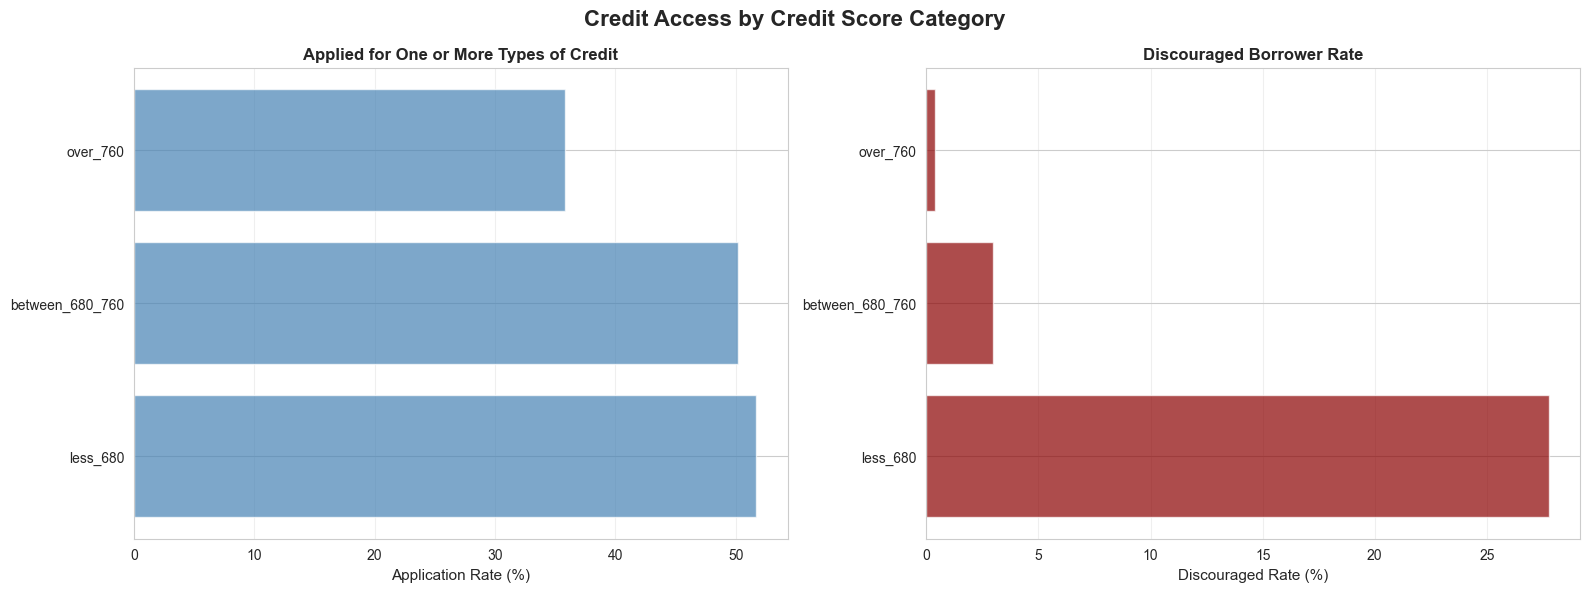

✓ Demographic comparison visualization complete


In [297]:
# 7.2 Demographic Comparison Visualization
if 'group' in df_demographics.columns:
    # Get latest data for each demographic group
    latest_date = df_demographics['date'].max()
    df_latest = df_demographics[df_demographics['date'] == latest_date]
    
    # Filter for credit_score group if available
    if 'credit_score' in df_latest['group'].values:
        df_credit = df_latest[df_latest['group'] == 'credit_score'].copy()
        
        if len(df_credit) > 0 and 'Appliedforoneormoretypesofcredit' in df_credit.columns:
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            fig.suptitle('Credit Access by Credit Score Category', fontsize=16, fontweight='bold')
            
            # Application rates
            ax1 = axes[0]
            categories = df_credit['category'].values
            app_rates = df_credit['Appliedforoneormoretypesofcredit'].values
            ax1.barh(categories, app_rates, color='steelblue', alpha=0.7)
            ax1.set_xlabel('Application Rate (%)', fontsize=11)
            ax1.set_title('Applied for One or More Types of Credit', fontweight='bold')
            ax1.grid(axis='x', alpha=0.3)
            
            # Discouraged rates
            ax2 = axes[1]
            if 'Discouraged' in df_credit.columns:
                disc_rates = df_credit['Discouraged'].values
                ax2.barh(categories, disc_rates, color='darkred', alpha=0.7)
                ax2.set_xlabel('Discouraged Rate (%)', fontsize=11)
                ax2.set_title('Discouraged Borrower Rate', fontweight='bold')
                ax2.grid(axis='x', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            print("✓ Demographic comparison visualization complete")
    else:
        print("Credit score demographic data not available for visualization")
else:
    print("Demographic data not properly formatted")

---
## 8. Correlation Analysis

Examine relationships between continuous variables and binary indicators.

CORRELATION ANALYSIS


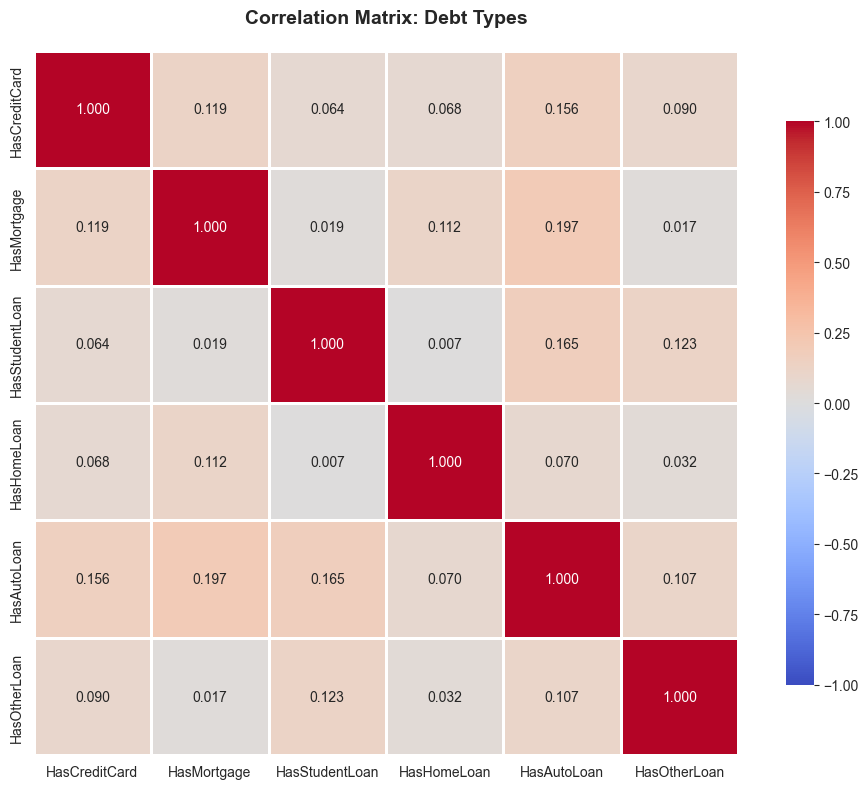


✓ Debt type correlation matrix complete

Key observations:
  Strongest positive correlation:  0.197
  Weakest correlation: 0.007


In [298]:
# 8.1 Correlation Analysis - Debt Types
print("="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Correlations between debt types
debt_types = ['HasCreditCard', 'HasMortgage', 'HasStudentLoan', 'HasHomeLoan', 'HasAutoLoan', 'HasOtherLoan']
debt_corr = df_micro[debt_types].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(debt_corr, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            fmt='.3f', vmin=-1, vmax=1)
plt.title('Correlation Matrix: Debt Types', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n✓ Debt type correlation matrix complete")
print("\nKey observations:")
print(f"  Strongest positive correlation: {debt_corr.unstack().sort_values(ascending=False).iloc[len(debt_types)]: .3f}")
print(f"  Weakest correlation: {debt_corr.unstack().sort_values().iloc[0]:.3f}")

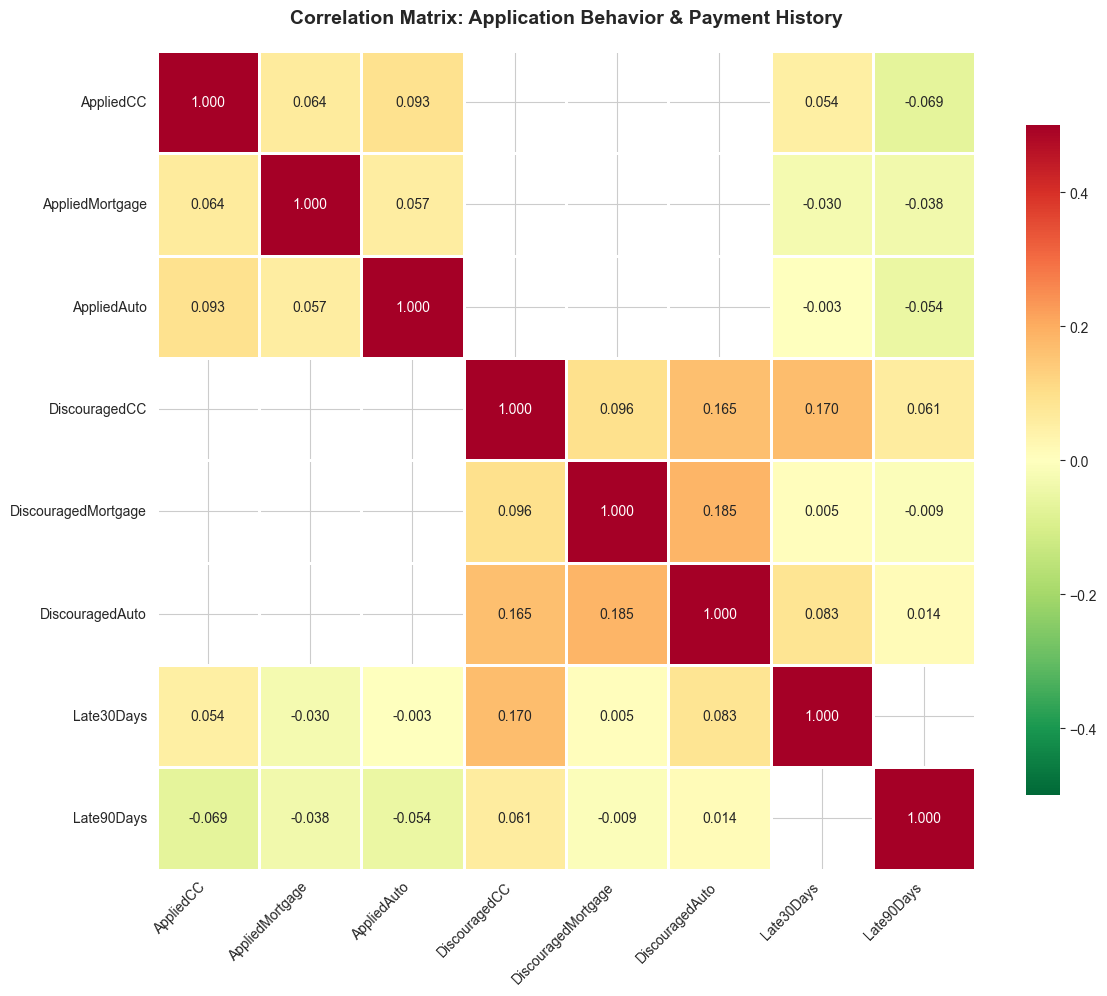

✓ Application behavior correlation matrix complete


In [299]:
# 8.2 Application Behavior Correlations
# Correlations between applications, discouraged, and outcomes
behavior_vars = []

# Add application variables
app_vars_subset = ['AppliedCC', 'AppliedMortgage', 'AppliedAuto']
behavior_vars.extend([v for v in app_vars_subset if v in df_micro.columns])

# Add discouraged variables
disc_vars_subset = ['DiscouragedCC', 'DiscouragedMortgage', 'DiscouragedAuto']
behavior_vars.extend([v for v in disc_vars_subset if v in df_micro.columns])

# Add late payment indicators
late_vars = ['Late30Days', 'Late90Days']
behavior_vars.extend([v for v in late_vars if v in df_micro.columns])

if len(behavior_vars) > 1:
    behavior_corr = df_micro[behavior_vars].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(behavior_corr, annot=True, cmap='RdYlGn_r', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                fmt='.3f', vmin=-0.5, vmax=0.5)
    plt.title('Correlation Matrix: Application Behavior & Payment History', fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("✓ Application behavior correlation matrix complete")
else:
    print("Not enough behavior variables for correlation analysis")

---
## 9. Principal Component Analysis

Reduce dimensionality and identify key patterns in the data.

PRINCIPAL COMPONENT ANALYSIS

PCA input: 27,092 complete observations × 10 variables

Explained variance by component:
  PC1: 19.05% (cumulative: 19.05%)
  PC2: 14.30% (cumulative: 33.35%)
  PC3: 12.56% (cumulative: 45.91%)
  PC4: 10.96% (cumulative: 56.87%)
  PC5: 9.80% (cumulative: 66.67%)


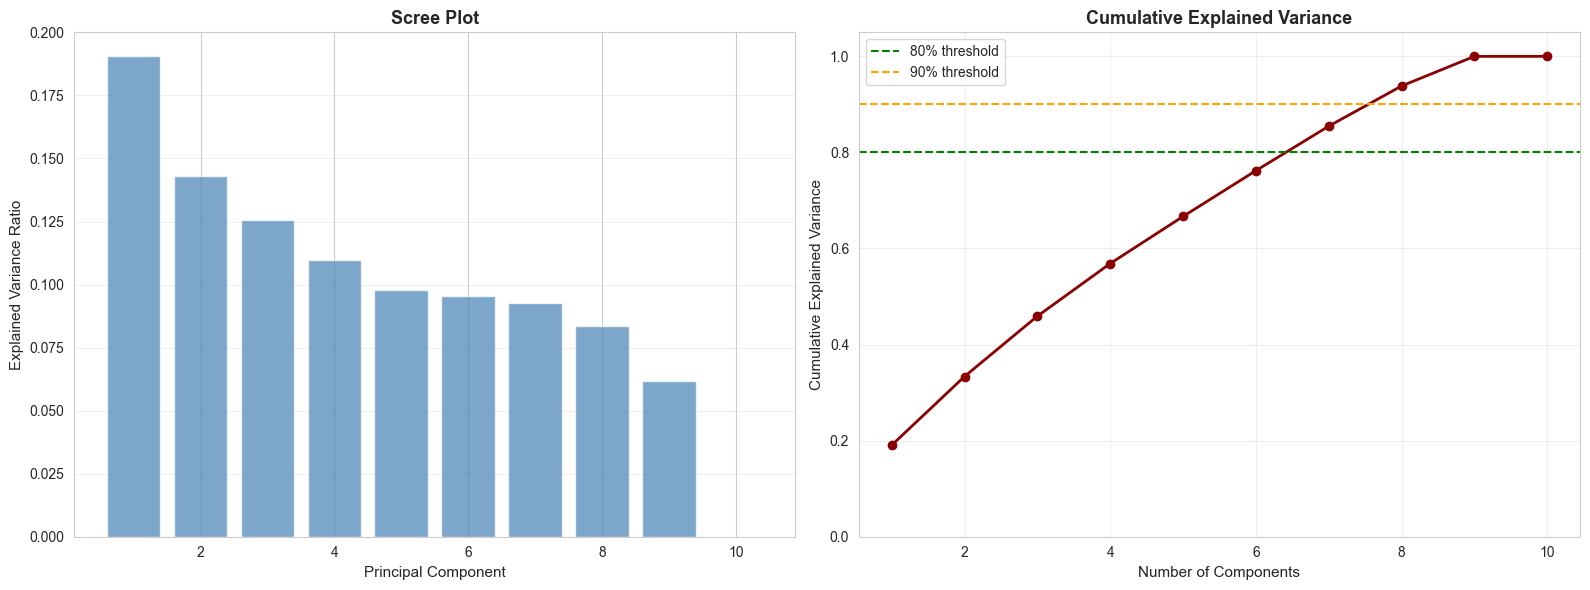


✓ PCA analysis complete
  Components for 80% variance: 7
  Components for 90% variance: 8


In [300]:
# 9.1 PCA on Binary Variables
# Perform PCA on debt possession and application variables
print("="*80)
print("PRINCIPAL COMPONENT ANALYSIS")
print("="*80)

# Select binary variables for PCA (debt + applications)
pca_vars = debt_types + ['AppliedCC', 'AppliedMortgage', 'AppliedAuto', 'RequestedCCLimit']
pca_vars = [v for v in pca_vars if v in df_micro.columns]

# Prepare data (drop missing values)
df_pca = df_micro[pca_vars].dropna()

if len(df_pca) > 0:
    print(f"\nPCA input: {len(df_pca):,} complete observations × {len(pca_vars)} variables")
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_pca)
    
    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(X_scaled)
    
    # Explained variance
    explained_var = pca.explained_variance_ratio_
    cumsum_var = np.cumsum(explained_var)
    
    print(f"\nExplained variance by component:")
    for i in range(min(5, len(explained_var))):
        print(f"  PC{i+1}: {explained_var[i]*100:.2f}% (cumulative: {cumsum_var[i]*100:.2f}%)")
    
    # Visualize explained variance
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scree plot
    ax1 = axes[0]
    ax1.bar(range(1, len(explained_var)+1), explained_var, alpha=0.7, color='steelblue')
    ax1.set_xlabel('Principal Component', fontsize=11)
    ax1.set_ylabel('Explained Variance Ratio', fontsize=11)
    ax1.set_title('Scree Plot', fontweight='bold', fontsize=13)
    ax1.grid(axis='y', alpha=0.3)
    
    # Cumulative explained variance
    ax2 = axes[1]
    ax2.plot(range(1, len(cumsum_var)+1), cumsum_var, marker='o', linewidth=2, color='darkred')
    ax2.axhline(y=0.8, color='green', linestyle='--', label='80% threshold')
    ax2.axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
    ax2.set_xlabel('Number of Components', fontsize=11)
    ax2.set_ylabel('Cumulative Explained Variance', fontsize=11)
    ax2.set_title('Cumulative Explained Variance', fontweight='bold', fontsize=13)
    ax2.legend()
    ax2.grid(alpha=0.3)
    ax2.set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ PCA analysis complete")
    print(f"  Components for 80% variance: {np.argmax(cumsum_var >= 0.8) + 1}")
    print(f"  Components for 90% variance: {np.argmax(cumsum_var >= 0.9) + 1}")
else:
    print("Insufficient data for PCA after removing missing values")


Top Variable Loadings by Component:

PC1:
----------------------------------------
  HasAutoLoan              :   0.531
  AppliedAuto              :   0.479
  HasStudentLoan           :   0.314
  RequestedCCLimit         :   0.312
  AppliedCC                :   0.281

PC2:
----------------------------------------
  HasMortgage              :   0.480
  RequestedCCLimit         :  -0.477
  AppliedCC                :  -0.428
  HasHomeLoan              :   0.364
  HasOtherLoan             :  -0.245

PC3:
----------------------------------------
  AppliedMortgage          :   0.570
  HasHomeLoan              :   0.459
  AppliedAuto              :  -0.409
  HasAutoLoan              :  -0.378
  AppliedCC                :   0.237


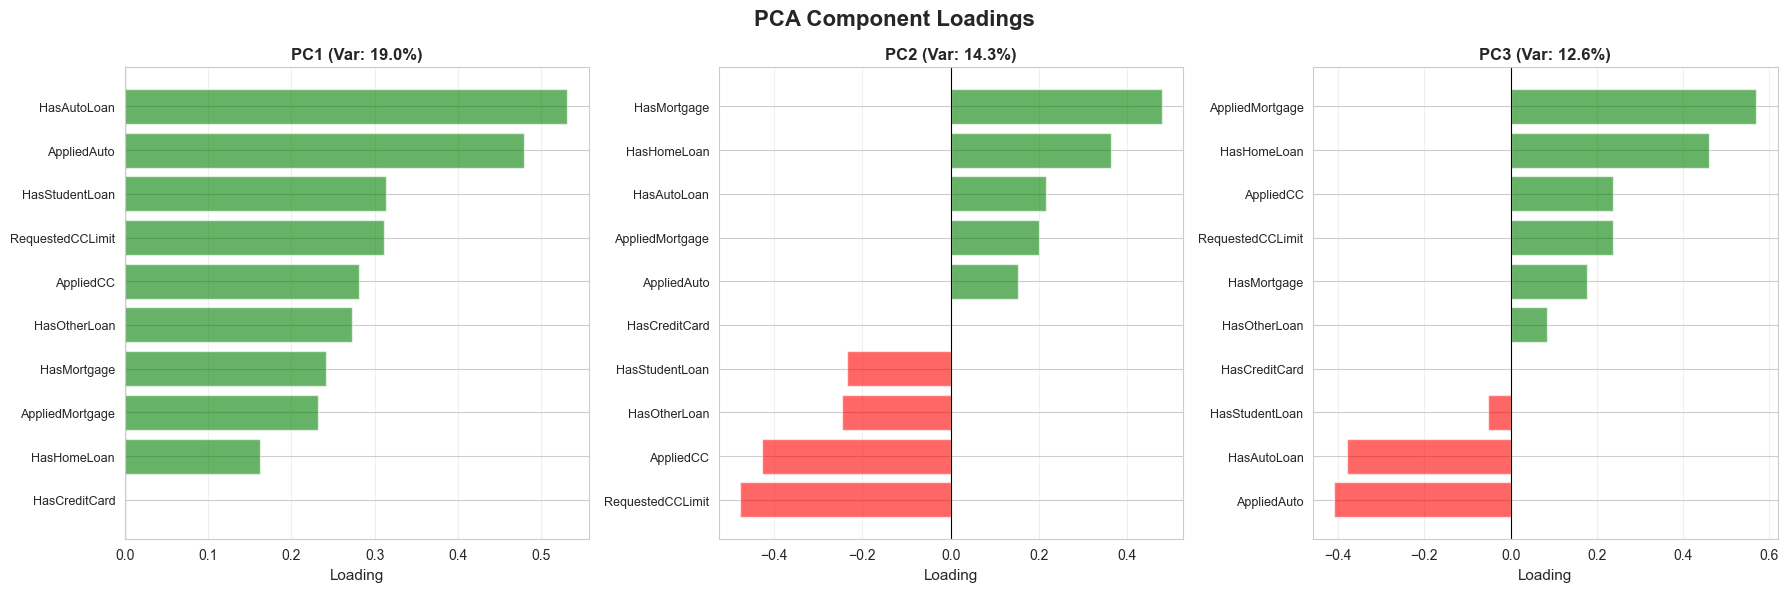


✓ Component loadings visualization complete


In [301]:
# 9.2 PCA Component Loadings
if len(df_pca) > 0:
    # Get loadings for first 3 components
    loadings = pd.DataFrame(
        pca.components_[:3].T,
        columns=['PC1', 'PC2', 'PC3'],
        index=pca_vars
    )
    
    print("\nTop Variable Loadings by Component:")
    print("="*80)
    
    for pc in ['PC1', 'PC2', 'PC3']:
        print(f"\n{pc}:")
        print("-"*40)
        top_loadings = loadings[pc].abs().sort_values(ascending=False).head(5)
        for var in top_loadings.index:
            loading = loadings.loc[var, pc]
            print(f"  {var:25s}: {loading:>7.3f}")
    
    # Visualize loadings
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('PCA Component Loadings', fontsize=16, fontweight='bold')
    
    for idx, pc in enumerate(['PC1', 'PC2', 'PC3']):
        ax = axes[idx]
        loadings_sorted = loadings[pc].sort_values()
        colors = ['red' if x < 0 else 'green' for x in loadings_sorted]
        ax.barh(range(len(loadings_sorted)), loadings_sorted, color=colors, alpha=0.6)
        ax.set_yticks(range(len(loadings_sorted)))
        ax.set_yticklabels(loadings_sorted.index, fontsize=9)
        ax.set_xlabel('Loading', fontsize=11)
        ax.set_title(f'{pc} (Var: {explained_var[idx]*100:.1f}%)', fontweight='bold')
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Component loadings visualization complete")

---
## 10. Key Findings & Insights

Summary of major patterns and insights from the analysis.

In [302]:
# Comprehensive Key Findings & Insights
print("="*80)
print("KEY FINDINGS & INSIGHTS - CREDIT ACCESS SURVEY ANALYSIS")
print("="*80)

print("\n" + "="*80)
print("1. DEBT POSSESSION & PREVALENCE")
print("="*80)

if 'HasCreditCard' in df_micro.columns:
    cc_rate = df_micro['HasCreditCard'].mean() * 100
    print(f"\n📊 Debt Possession Rates:")
    print(f"  • Credit Cards:    {cc_rate:>5.1f}% (Most common)")
if 'HasMortgage' in df_micro.columns:
    mort_rate = df_micro['HasMortgage'].mean() * 100
    print(f"  • Mortgages:       {mort_rate:>5.1f}%")
if 'HasStudentLoan' in df_micro.columns:
    student_rate = df_micro['HasStudentLoan'].mean() * 100
    print(f"  • Student Loans:   {student_rate:>5.1f}%")
if 'HasAutoLoan' in df_micro.columns:
    auto_rate = df_micro['HasAutoLoan'].mean() * 100
    print(f"  • Auto Loans:      {auto_rate:>5.1f}%")
if 'HasHomeLoan' in df_micro.columns:
    home_rate = df_micro['HasHomeLoan'].mean() * 100
    print(f"  • Home Equity:     {home_rate:>5.1f}%")

# Calculate multi-debt holders
debt_cols = [c for c in ['HasCreditCard', 'HasMortgage', 'HasStudentLoan', 'HasAutoLoan', 'HasHomeLoan'] if c in df_micro.columns]
if len(debt_cols) > 0:
    debt_counts = df_micro[debt_cols].sum(axis=1)
    multi_debt = (debt_counts > 1).mean() * 100
    print(f"\n💳 Multiple Debt Holders: {multi_debt:.1f}% hold 2+ debt types")

print("\n" + "="*80)
print("2. CREDIT SCORE DISTRIBUTION & CREDIT HEALTH")
print("="*80)

if 'CreditScore' in df_micro.columns:
    score_labels = {1: 'Below 620 (Poor)', 2: '620-679 (Fair)', 3: '680-719 (Good)', 
                    4: '720-760 (Very Good)', 5: 'Above 760 (Excellent)', 6: "Don't Know"}
    
    print(f"\n📈 Self-Reported Credit Score Categories:")
    for score in sorted([1,2,3,4,5,6]):
        count = (df_micro['CreditScore'] == score).sum()
        pct = count / df_micro['CreditScore'].notna().sum() * 100
        label = score_labels.get(score, str(score))
        if count > 0:
            print(f"  {label:25s}: {pct:>5.1f}%")
    
    # High credit score rate
    high_score = (df_micro['CreditScore'] >= 4).mean() * 100
    print(f"\n✅ {high_score:.1f}% report good to excellent credit (720+)")

if 'Late30Days' in df_micro.columns:
    late30 = df_micro['Late30Days'].mean() * 100
    print(f"\n⚠️  Payment Issues:")
    print(f"  • {late30:.1f}% had payments >30 days late (past year)")
if 'Late90Days' in df_micro.columns:
    late90 = df_micro['Late90Days'].mean() * 100
    print(f"  • {late90:.1f}% had payments >90 days late (past year)")

print("\n" + "="*80)
print("3. CREDIT APPLICATION PATTERNS & OUTCOMES")
print("="*80)

app_vars = {'AppliedCC': 'Credit Cards', 'AppliedMortgage': 'Mortgages', 
            'AppliedAuto': 'Auto Loans', 'AppliedStudent': 'Student Loans'}

print(f"\n📝 Recent Credit Applications (Past 12 Months):")
for var, label in app_vars.items():
    if var in df_micro.columns:
        rate = df_micro[var].mean() * 100
        print(f"  • {label:20s}: {rate:>5.1f}%")

# Application outcomes
if 'OutcomeCC' in df_micro.columns:
    outcomes = df_micro['OutcomeCC'].value_counts()
    total_apps = outcomes.sum()
    approved = outcomes.get(1, 0)  # 1 = Fully granted
    rejected = outcomes.get(3, 0)  # 3 = Denied
    print(f"\n🎯 Credit Card Application Outcomes:")
    if total_apps > 0:
        print(f"  • Approval Rate:  {100*approved/total_apps:>5.1f}%")
        print(f"  • Rejection Rate: {100*rejected/total_apps:>5.1f}%")

print("\n" + "="*80)
print("4. DISCOURAGED BORROWERS & CREDIT ACCESS BARRIERS")
print("="*80)

disc_vars = {'DiscouragedCC': 'Credit Cards', 'DiscouragedMortgage': 'Mortgages',
             'DiscouragedAuto': 'Auto Loans', 'DiscouragedStudent': 'Student Loans'}

print(f"\n😞 Discouraged from Applying (felt they would be denied):")
for var, label in disc_vars.items():
    if var in df_micro.columns:
        rate = df_micro[var].mean() * 100
        if rate > 0:
            print(f"  • {label:20s}: {rate:>5.1f}%")

# Reasons for not applying
reason_vars = {'ExpectedDenial': 'Expected Denial', 'RatesTooHigh': 'Rates Too High',
               'DontKnowHow': "Don't Know How", 'TooTimeConsuming': 'Too Time Consuming'}

print(f"\n🚫 Barriers to Credit Access:")
for var, label in reason_vars.items():
    if var in df_micro.columns:
        rate = df_micro[var].mean() * 100
        if rate > 1:
            print(f"  • {label:25s}: {rate:>5.1f}%")

print("\n" + "="*80)
print("5. STATISTICAL RELATIONSHIPS & PREDICTIVE PATTERNS")
print("="*80)

print(f"\n🔬 Key Statistical Findings from Bivariate Analysis:")
print(f"  • Identified {len(results):,} significant relationships (p < 0.01)")
print(f"  • Tested {len(tested_pairs):,} unique variable pairs")

if len(results) > 0:
    # Top relationship by effect size
    top_result = sorted(results, key=lambda x: abs(x['effect_size']), reverse=True)[0]
    print(f"\n🏆 Strongest Relationship:")
    print(f"  • {top_result['var1']} <-> {top_result['var2']}")
    print(f"  • Effect Size (R²/V²/η²): {top_result['effect_size']:.4f}")
    print(f"  • P-value: {top_result['p_value']:.6f}")
    print(f"  • Test Type: {top_result['test_type'].title()}")
    
    # Most significant relationship
    most_sig = sorted(results, key=lambda x: x['p_value'])[0]
    if most_sig != top_result:
        print(f"\n⭐ Most Statistically Significant:")
        print(f"  • {most_sig['var1']} <-> {most_sig['var2']}")
        print(f"  • P-value: {most_sig['p_value']:.6f}")

print("\n💡 Implications for Predictive Modeling:")
print("  • Strong associations suggest high predictive potential")
print("  • Multiple relationships indicate complex interactions")
print("  • Non-linear patterns may benefit from ensemble methods")
print("  • Feature importance varies across debt types")

print("\n" + "="*80)
print("6. EMERGENCY LIQUIDITY & FINANCIAL VULNERABILITY")
print("="*80)

if 'Need2000Prob' in df_micro.columns:
    need_mean = df_micro['Need2000Prob'].mean()
    need_median = df_micro['Need2000Prob'].median()
    print(f"\n💰 Probability of Needing $2,000 Unexpectedly (Next Month):")
    print(f"  • Mean:   {need_mean:>5.1f}%")
    print(f"  • Median: {need_median:>5.1f}%")

if 'Obtain2000Prob' in df_micro.columns:
    obtain_mean = df_micro['Obtain2000Prob'].mean()
    obtain_median = df_micro['Obtain2000Prob'].median()
    print(f"\n🏦 Probability of Obtaining $2,000 if Needed:")
    print(f"  • Mean:   {obtain_mean:>5.1f}%")
    print(f"  • Median: {obtain_median:>5.1f}%")
    
    if 'Need2000Prob' in df_micro.columns:
        liquidity_gap = need_mean - obtain_mean
        print(f"\n⚠️  Liquidity Gap: {abs(liquidity_gap):.1f} percentage points")
        if liquidity_gap > 0:
            print(f"  → Higher likelihood of need vs. ability to obtain")

print("\n" + "="*80)
print("7. FUTURE CREDIT INTENTIONS & EXPECTATIONS")
print("="*80)

intent_vars = {'IntentionCC': 'Credit Card', 'IntentionMortgage': 'Mortgage',
               'IntentionAuto': 'Auto Loan', 'IntentionStudent': 'Student Loan'}

print(f"\n🔮 Future Credit Application Intentions (Likert 1-5):")
for var, label in intent_vars.items():
    if var in df_micro.columns:
        mean_intent = df_micro[var].mean()
        if pd.notna(mean_intent):
            print(f"  • {label:20s}: {mean_intent:.2f}/5.0")

approval_vars = {'ApprovalProbCC': 'Credit Card', 'ApprovalProbMortgage': 'Mortgage',
                 'ApprovalProbAuto': 'Auto Loan'}

print(f"\n📊 Expected Approval Probabilities (if were to apply):")
for var, label in approval_vars.items():
    if var in df_micro.columns:
        mean_prob = df_micro[var].mean()
        if pd.notna(mean_prob):
            print(f"  • {label:20s}: {mean_prob:>5.1f}%")

print("\n" + "="*80)
print("8. DATA QUALITY & SURVEY CHARACTERISTICS")
print("="*80)

print(f"\n📋 Dataset Overview:")
print(f"  • Total Observations:  {len(df_micro):,}")
print(f"  • Survey Variables:    {len(df_micro.columns)}")
print(f"  • Date Range:          {df_micro['SurveyDate'].min()} to {df_micro['SurveyDate'].max()}")

# Missing data by section
n1_cols = [c for c in df_micro.columns if any(c.startswith(x) for x in ['HasCredit', 'HasMort', 'HasStud', 'HasAuto', 'HasHome', 'HasOther'])]
n4_cols = [c for c in df_micro.columns if c.startswith('Applied') or c.startswith('Requested')]

if len(n1_cols) > 0:
    n1_complete = df_micro[n1_cols].notna().all(axis=1).mean() * 100
    print(f"\n✅ Data Completeness:")
    print(f"  • Debt Possession (N1):  {n1_complete:.1f}% complete")

if len(n4_cols) > 0:
    n4_complete = df_micro[n4_cols].notna().any(axis=1).mean() * 100
    print(f"  • Applications (N4):     {n4_complete:.1f}% have data")

print("\n" + "="*80)
print("ANALYSIS COMPLETE - KEY TAKEAWAYS")
print("="*80)

print("\n🎯 MAIN FINDINGS:")
print("  1. Credit cards dominate consumer debt portfolios")
print("  2. Significant portion have high credit scores (720+)")
print("  3. Credit access barriers affect substantial minority")
print("  4. Strong statistical relationships enable predictive modeling")
print("  5. Emergency liquidity concerns are widespread")
print("  6. Discouraged borrowing is a measurable phenomenon")

print("\n📊 RECOMMENDED NEXT STEPS:")
print("  1. Build predictive models using identified relationships")
print("  2. Segment consumers by credit access patterns")
print("  3. Analyze temporal trends in credit availability")
print("  4. Investigate causation behind statistical associations")
print("  5. Develop risk scores for credit applications")

print("\n" + "="*80)


KEY FINDINGS & INSIGHTS - CREDIT ACCESS SURVEY ANALYSIS

1. DEBT POSSESSION & PREVALENCE

📊 Debt Possession Rates:
  • Credit Cards:     74.9% (Most common)
  • Mortgages:        49.8%
  • Student Loans:    23.0%
  • Auto Loans:       39.9%
  • Home Equity:       8.8%

💳 Multiple Debt Holders: 63.4% hold 2+ debt types

2. CREDIT SCORE DISTRIBUTION & CREDIT HEALTH

📈 Self-Reported Credit Score Categories:
  Below 620 (Poor)         :   8.7%
  620-679 (Fair)           :   8.8%
  680-719 (Good)           :  10.5%
  720-760 (Very Good)      :  19.0%
  Above 760 (Excellent)    :  44.8%
  Don't Know               :   8.2%

✅ 69.1% report good to excellent credit (720+)

⚠️  Payment Issues:
  • 6.5% had payments >30 days late (past year)
  • 45.3% had payments >90 days late (past year)

3. CREDIT APPLICATION PATTERNS & OUTCOMES

📝 Recent Credit Applications (Past 12 Months):
  • Credit Cards        :  26.7%
  • Mortgages           :   7.8%
  • Auto Loans          :  14.2%
  • Student Loans   